In [2]:
# LOAD Packages 
import uproot
import pandas as pd
import numpy as np
import awkward as ak
!pip install awkward_pandas
!pip install texlive
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
#matplotlib.rcParams.update(matplotlib.rcParamsDefault)
#matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
import os
import math
import csv
import seaborn as sns
import sympy as smp
import sympy.stats
import json
from scipy import stats,signal,ndimage,special,fft
from scipy.optimize import curve_fit
from scipy.integrate import quad
from mpl_toolkits.axes_grid1 import make_axes_locatable

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement texlive (from versions: none)

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
ERROR: No matching distribution found for texlive


In [3]:
# Open CAF File 
showers = uproot.open("/global/cfs/cdirs/dune/users/ehinkle/nd_prototypes_ana/2x2_CC_pi0/caf_studies/plotting/pi0_all_showers_from_CC1pi0_truth_sig_bkg_dict_events.root")
showers["RecoBenchmarkTree"].show()
showers["RecoBenchmarkTree"].keys()
showers["RecoBenchmarkTree"][0].num_entries

# Load CAF File into DataFrame
ak_array = showers["RecoBenchmarkTree"].arrays(library="ak")
caf_df = ak.to_dataframe(ak_array)
caf_df = caf_df.reset_index(drop=True)
num_entries = len(caf_df)
print("Number of Entries: ", num_entries)
caf_df.head()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
reco_energy          | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_p_x             | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_p_y             | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_p_z             | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_p_mag           | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle           | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_shower_to_vt... | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle_x         | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle_y         | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle_z         | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_shower_start_x  | std::

,reco_energy,reco_p_x,reco_p_y,reco_p_z,reco_p_mag,reco_angle,reco_shower_to_vtx_dist,reco_angle_x,reco_angle_y,reco_angle_z,...,true_ixn_vtx_z_pos,spill_index,file_index,event,run,subrun,caf_file_name,truth_dict_key,ixn_overlap,part_overlap
0,0.050735,-0.041913,0.016053,-0.024731,0.051245,2.094442,1.828186,2.528536,1.252160,2.074427,...,-31.0,14,0,13,0,0,MiniRun6.2_1E19_RHC.caf.0000000.CAF.flat.root,14-61,0.978903,1.000000
1,0.237022,-0.145679,0.159656,0.097299,0.237022,1.191180,4.366984,2.232704,0.831740,1.147788,...,-31.0,14,0,13,0,0,MiniRun6.2_1E19_RHC.caf.0000000.CAF.flat.root,14-61,0.978903,0.968504
2,0.108782,0.025101,-0.056085,-0.089766,0.108782,2.487747,55.224218,1.337951,2.112475,2.541335,...,-31.0,14,0,13,0,0,MiniRun6.2_1E19_RHC.caf.0000000.CAF.flat.root,14-61,0.978903,0.948113
3,0.035297,-0.005653,-0.034884,0.005755,0.035805,1.351816,71.972985,1.729342,2.914329,1.409351,...,-31.0,14,0,13,0,0,MiniRun6.2_1E19_RHC.caf.0000000.CAF.flat.root,14-61,0.978903,0.614035
4,0.007117,0.000000,-0.005383,-0.005383,0.007612,2.297896,101.137002,1.570796,2.356199,2.356190,...,-31.0,14,0,13,0,0,MiniRun6.2_1E19_RHC.caf.0000000.CAF.flat.root,14-61,0.978903,0.123894


In [4]:
# Load Truth/Background Dictionary
sig_bkg_file = open("/global/cfs/cdirs/dune/users/ehinkle/nd_prototypes_ana/2x2_CC_pi0/caf_studies/plotting/combined_CC1pi0_sig_bkg_dict.json")
sig_bkg_dict = json.load(sig_bkg_file)
sig_bkg_df = pd.DataFrame(sig_bkg_dict)
sig_bkg_df = sig_bkg_df.transpose()
sig_bkg_df["dict_key"] = sig_bkg_df.index
sig_bkg_df.head()

print("Number of Entries in sig_bkg_df: ", len(sig_bkg_df))
signal_only_sig_bkg_df = sig_bkg_df[sig_bkg_df["sig"] == True]
print("Number of Entries in signal_only_sig_bkg_df: ", len(signal_only_sig_bkg_df))
signal_only_decay_diphoton_df = signal_only_sig_bkg_df[signal_only_sig_bkg_df["pi0_child_pdg"].apply(lambda x: np.array(x).shape == (1,2))]
print("Number of Entries in signal_only_decay_diphoton_df: ", len(signal_only_decay_diphoton_df))

Number of Entries in sig_bkg_df:  7937
Number of Entries in signal_only_sig_bkg_df:  1195
Number of Entries in signal_only_decay_diphoton_df:  1181


In [5]:
# Match across dataframes -- add truth info to caf_df
full_df = caf_df
full_df = full_df.join(sig_bkg_df.set_index('dict_key'), on='truth_dict_key', how='outer')
full_df.head()

,reco_energy,reco_p_x,reco_p_y,reco_p_z,reco_p_mag,reco_angle,reco_shower_to_vtx_dist,reco_angle_x,reco_angle_y,reco_angle_z,...,primary_shower_start_pxyz,primary_shower_conv_dist,nu_energy,q2,vtx_x,vtx_y,vtx_z,filepath,flow_event_id,file_number
0.0,0.050735,-0.041913,0.016053,-0.024731,0.051245,2.094442,1.828186,2.528536,1.252160,2.074427,...,[],[],5769.64502,224041.5,-6.306443,33.977135,-31.177608,/global/cfs/cdirs/dune/users/ehinkle/nd_protot...,13,0
1.0,0.237022,-0.145679,0.159656,0.097299,0.237022,1.191180,4.366984,2.232704,0.831740,1.147788,...,[],[],5769.64502,224041.5,-6.306443,33.977135,-31.177608,/global/cfs/cdirs/dune/users/ehinkle/nd_protot...,13,0
2.0,0.108782,0.025101,-0.056085,-0.089766,0.108782,2.487747,55.224218,1.337951,2.112475,2.541335,...,[],[],5769.64502,224041.5,-6.306443,33.977135,-31.177608,/global/cfs/cdirs/dune/users/ehinkle/nd_protot...,13,0
3.0,0.035297,-0.005653,-0.034884,0.005755,0.035805,1.351816,71.972985,1.729342,2.914329,1.409351,...,[],[],5769.64502,224041.5,-6.306443,33.977135,-31.177608,/global/cfs/cdirs/dune/users/ehinkle/nd_protot...,13,0
4.0,0.007117,0.000000,-0.005383,-0.005383,0.007612,2.297896,101.137002,1.570796,2.356199,2.356190,...,[],[],5769.64502,224041.5,-6.306443,33.977135,-31.177608,/global/cfs/cdirs/dune/users/ehinkle/nd_protot...,13,0


In [6]:
# Filter to CC 1pi0 events
#cc1pi0_0chpi_df = full_df[full_df["sig"] == True]
cc1pi0_0chpi_df = full_df[full_df["pi0_mult"] == 1]
num_events = len(np.unique(cc1pi0_0chpi_df["truth_dict_key"]))
num_showers = len(cc1pi0_0chpi_df)
print("Number of Showers: ", num_showers)
print("Number of CC 1pi0 0chpi Events: ", num_events)

# Filter by decay mode (truth)
print("Decay Modes: ", np.unique(cc1pi0_0chpi_df["pi0_child_pdg"]))
cc1pi0_0chpi_df = cc1pi0_0chpi_df[cc1pi0_0chpi_df["pi0_child_pdg"].apply(lambda x: np.array(x).shape == (1,2))]
print("Decay Modes: ", np.unique(cc1pi0_0chpi_df["pi0_child_pdg"]))
num_events = len(np.unique(cc1pi0_0chpi_df["truth_dict_key"]))
print("Number of CC 1pi0 0chpi Events: ", num_events)

Number of Showers:  15635
Number of CC 1pi0 0chpi Events:  3866
Decay Modes:  [list([[]]) list([[-11, 11, 22]]) list([[22, 22]])]
Decay Modes:  [list([[22, 22]])]
Number of CC 1pi0 0chpi Events:  3790


In [7]:
# Set up df to look at containment by event: 
unique_events = np.unique(cc1pi0_0chpi_df["truth_dict_key"])
containment_df = pd.DataFrame()
containment_df["truth_dict_key"] = unique_events

# Set allowances for xyz matching of shower starts
x_allowance = 1.5
y_allowance = 1.5
z_allowance = 1.5

# Loop over events to add info to check containment
for event in unique_events:

    # Initialize flags
    lead_match_found = False
    sublead_match_found = False
    current_lead_max_energy = 0
    current_sublead_max_energy = 0

    # Get all showers in event from full df
    event_df = cc1pi0_0chpi_df[cc1pi0_0chpi_df["truth_dict_key"] == event]
    event_df = event_df.reset_index(drop=True)

    # Initialize reco info
    containment_df.loc[containment_df["truth_dict_key"] == event, "lead_reco_E"] = 0
    containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_reco_E"] = 0
    containment_df.loc[containment_df["truth_dict_key"] == event, "lead_reco_px"] = 0
    containment_df.loc[containment_df["truth_dict_key"] == event, "lead_reco_py"] = 0
    containment_df.loc[containment_df["truth_dict_key"] == event, "lead_reco_pz"] = 0
    containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_reco_px"] = 0
    containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_reco_py"] = 0
    containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_reco_pz"] = 0
    containment_df.loc[containment_df["truth_dict_key"] == event, "lead_reco_start_x"] = 0
    containment_df.loc[containment_df["truth_dict_key"] == event, "lead_reco_start_y"] = 0
    containment_df.loc[containment_df["truth_dict_key"] == event, "lead_reco_start_z"] = 0
    containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_reco_start_x"] = 0
    containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_reco_start_y"] = 0
    containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_reco_start_z"] = 0
    containment_df.loc[containment_df["truth_dict_key"] == event, "num_reco_events"] = len(np.unique(event_df['flow_event_id'])) # number of reco events associated with this truth event
    containment_df.loc[containment_df["truth_dict_key"] == event, "num_extra_lead_reco_showers"] = 0
    containment_df.loc[containment_df["truth_dict_key"] == event, "num_extra_sublead_reco_showers"] = 0
    containment_df.loc[containment_df["truth_dict_key"] == event, "num_extra_unmatched_reco_showers"] = 0
    containment_df.loc[containment_df["truth_dict_key"] == event, "lead_reco_pdg"] = 0
    containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_reco_pdg"] = 0
    containment_df.loc[containment_df["truth_dict_key"] == event, "true_ixn_vtx_x_pos"] = 0
    containment_df.loc[containment_df["truth_dict_key"] == event, "true_ixn_vtx_y_pos"] = 0
    containment_df.loc[containment_df["truth_dict_key"] == event, "true_ixn_vtx_z_pos"] = 0
    containment_df.loc[containment_df["truth_dict_key"] == event, "reco_ixn_vtx_x_pos"] = 0
    containment_df.loc[containment_df["truth_dict_key"] == event, "reco_ixn_vtx_y_pos"] = 0
    containment_df.loc[containment_df["truth_dict_key"] == event, "reco_ixn_vtx_z_pos"] = 0

    # Loop over showers in event to add to containment df
    num_reco_showers = len(event_df)

    for i in range(num_reco_showers):
        shower = event_df.iloc[i]

        # Some info only needs to be loaded once per event
        if i == 0:

            # Load true pi0 info 
            containment_df.loc[containment_df["truth_dict_key"] == event, "pi0_true_KE"] = shower["pi0_ke"][0]

            # Load available energy info
            if shower["pi0_child_available_energy"][0][0] > shower["pi0_child_available_energy"][0][1]:
                lead_shower_idx = 0
                sublead_shower_idx = 1
            else:
                lead_shower_idx = 1
                sublead_shower_idx = 0
            containment_df.loc[containment_df["truth_dict_key"] == event, "lead_available_E"] = shower["pi0_child_available_energy"][0][lead_shower_idx]
            containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_available_E"] = shower["pi0_child_available_energy"][0][sublead_shower_idx]

            # Load true pxyz info
            lead_pi0_child_pxyz = shower["pi0_child_start_pxyz"][0][lead_shower_idx]
            sublead_pi0_child_pxyz = shower["pi0_child_start_pxyz"][0][sublead_shower_idx]
            containment_df.loc[containment_df["truth_dict_key"] == event, "lead_true_px"] = lead_pi0_child_pxyz[0]
            containment_df.loc[containment_df["truth_dict_key"] == event, "lead_true_py"] = lead_pi0_child_pxyz[1]
            containment_df.loc[containment_df["truth_dict_key"] == event, "lead_true_pz"] = lead_pi0_child_pxyz[2]
            containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_true_px"] = sublead_pi0_child_pxyz[0]
            containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_true_py"] = sublead_pi0_child_pxyz[1]
            containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_true_pz"] = sublead_pi0_child_pxyz[2]

            # Load true interaction vertex location info
            containment_df.loc[containment_df["truth_dict_key"] == event, "true_ixn_vtx_x_pos"] = shower["true_ixn_vtx_x_pos"]
            print("true_ixn_vtx_x_pos: ", shower["true_ixn_vtx_x_pos"])
            
            containment_df.loc[containment_df["truth_dict_key"] == event, "true_ixn_vtx_y_pos"] = shower["true_ixn_vtx_y_pos"]
            #print("true_ixn_vtx_y_pos: ", shower["true_ixn_vtx_y_pos"])
            containment_df.loc[containment_df["truth_dict_key"] == event, "true_ixn_vtx_z_pos"] = shower["true_ixn_vtx_z_pos"]
            #print("true_ixn_vtx_z_pos: ", shower["true_ixn_vtx_z_pos"])

            # Load reco interaction vertex location info
            containment_df.loc[containment_df["truth_dict_key"] == event, "reco_ixn_vtx_x_pos"] = shower["reco_ixn_vtx_x_pos"]
            containment_df.loc[containment_df["truth_dict_key"] == event, "reco_ixn_vtx_y_pos"] = shower["reco_ixn_vtx_y_pos"]
            containment_df.loc[containment_df["truth_dict_key"] == event, "reco_ixn_vtx_z_pos"] = shower["reco_ixn_vtx_z_pos"]
            

            # Load true shower deposition energy
            containment_df.loc[containment_df["truth_dict_key"] == event, "lead_depo_E"] = shower["pi0_child_edep"][0][lead_shower_idx]
            containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_depo_E"] = shower["pi0_child_edep"][0][sublead_shower_idx]

            # Load primary shower info
            containment_df.loc[containment_df["truth_dict_key"] == event, "num_extra_true_primary_showers"] = len(shower["primary_shower_pdg"])

            # Load pi0 child deposition start information to match with reco showers
            lead_pi0_child_xyz = shower["pi0_child_edep_start"][0][lead_shower_idx]
            sublead_pi0_child_xyz= shower["pi0_child_edep_start"][0][sublead_shower_idx]
            containment_df.loc[containment_df["truth_dict_key"] == event, "lead_edep_start_x"] = lead_pi0_child_xyz[0]
            containment_df.loc[containment_df["truth_dict_key"] == event, "lead_edep_start_y"] = lead_pi0_child_xyz[1]
            containment_df.loc[containment_df["truth_dict_key"] == event, "lead_edep_start_z"] = lead_pi0_child_xyz[2]
            containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_edep_start_x"] = sublead_pi0_child_xyz[0]
            containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_edep_start_y"] = sublead_pi0_child_xyz[1]
            containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_edep_start_z"] = sublead_pi0_child_xyz[2]

        # Load shower info to check with truth info
        shower_start_x = shower["reco_shower_start_x"]
        shower_start_y = shower["reco_shower_start_y"]
        shower_start_z = shower["reco_shower_start_z"]

        # Check if reco shower matches with lead or sublead pi0 child based on start location of shower deposition
        if ((abs(lead_pi0_child_xyz[0] - shower_start_x) <= x_allowance) and \
            (abs(lead_pi0_child_xyz[1] - shower_start_y) <= y_allowance) and \
            (abs(lead_pi0_child_xyz[2] - shower_start_z) <= z_allowance)):

            if lead_match_found == True:
                containment_df.loc[containment_df["truth_dict_key"] == event, "num_extra_lead_reco_showers"] += 1
                if shower["reco_energy"] * 1000 > current_lead_max_energy:
                    current_lead_max_energy = shower["reco_energy"] * 1000 # convert to MeV
                    containment_df.loc[containment_df["truth_dict_key"] == event, "lead_reco_E"] = current_lead_max_energy
                    containment_df.loc[containment_df["truth_dict_key"] == event, "lead_reco_pdg"] = shower["reco_pdg"]
                    containment_df.loc[containment_df["truth_dict_key"] == event, "lead_reco_px"] = shower["reco_p_x"] * 1000 # convert to MeV
                    containment_df.loc[containment_df["truth_dict_key"] == event, "lead_reco_py"] = shower["reco_p_y"] * 1000 # convert to MeV
                    containment_df.loc[containment_df["truth_dict_key"] == event, "lead_reco_pz"] = shower["reco_p_z"] * 1000 # convert to MeV
                    containment_df.loc[containment_df["truth_dict_key"] == event, "lead_reco_start_x"] = shower_start_x
                    containment_df.loc[containment_df["truth_dict_key"] == event, "lead_reco_start_y"] = shower_start_y
                    containment_df.loc[containment_df["truth_dict_key"] == event, "lead_reco_start_z"] = shower_start_z
                continue
            if lead_match_found == False:
                lead_match_found = True
                current_lead_max_energy = shower["reco_energy"] * 1000 # convert to MeV
                containment_df.loc[containment_df["truth_dict_key"] == event, "lead_reco_E"] = current_lead_max_energy
                containment_df.loc[containment_df["truth_dict_key"] == event, "lead_reco_pdg"] = shower["reco_pdg"]
                containment_df.loc[containment_df["truth_dict_key"] == event, "lead_reco_px"] = shower["reco_p_x"] * 1000 # convert to MeV
                containment_df.loc[containment_df["truth_dict_key"] == event, "lead_reco_py"] = shower["reco_p_y"] * 1000 # convert to MeV
                containment_df.loc[containment_df["truth_dict_key"] == event, "lead_reco_pz"] = shower["reco_p_z"] * 1000 # convert to MeV
                containment_df.loc[containment_df["truth_dict_key"] == event, "lead_reco_start_x"] = shower_start_x
                containment_df.loc[containment_df["truth_dict_key"] == event, "lead_reco_start_y"] = shower_start_y
                containment_df.loc[containment_df["truth_dict_key"] == event, "lead_reco_start_z"] = shower_start_z
                continue

        if ((abs(sublead_pi0_child_xyz[0] - shower_start_x) <= x_allowance) and \
            (abs(sublead_pi0_child_xyz[1] - shower_start_y) <= y_allowance) and \
            (abs(sublead_pi0_child_xyz[2] - shower_start_z) <= z_allowance)):

            if sublead_match_found == True:
                containment_df.loc[containment_df["truth_dict_key"] == event, "num_extra_sublead_reco_showers"] += 1
                if shower["reco_energy"] * 1000 > current_sublead_max_energy:
                    current_sublead_max_energy = shower["reco_energy"] * 1000 # convert to MeV
                    containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_reco_E"] = current_sublead_max_energy
                    containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_reco_pdg"] = shower["reco_pdg"]
                    containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_reco_px"] = shower["reco_p_x"] * 1000 # convert to MeV
                    containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_reco_py"] = shower["reco_p_y"] * 1000 # convert to MeV
                    containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_reco_pz"] = shower["reco_p_z"] * 1000 # convert to MeV
                    containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_reco_start_x"] = shower_start_x
                    containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_reco_start_y"] = shower_start_y
                    containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_reco_start_z"] = shower_start_z
                continue
            if sublead_match_found == False:
                sublead_match_found = True
                current_sublead_max_energy = shower["reco_energy"] * 1000 # convert to MeV
                containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_reco_E"] = current_sublead_max_energy
                containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_reco_pdg"] = shower["reco_pdg"]
                containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_reco_px"] = shower["reco_p_x"] * 1000 # convert to MeV
                containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_reco_py"] = shower["reco_p_y"] * 1000 # convert to MeV
                containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_reco_pz"] = shower["reco_p_z"] * 1000 # convert to MeV
                containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_reco_start_x"] = shower_start_x
                containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_reco_start_y"] = shower_start_y
                containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_reco_start_z"] = shower_start_z
                continue

        # Add to extra showers if not matched with lead or sublead
        containment_df.loc[containment_df["truth_dict_key"] == event, "num_extra_unmatched_reco_showers"] += 1


true_ixn_vtx_x_pos:  12.0
true_ixn_vtx_x_pos:  56.0
true_ixn_vtx_x_pos:  -41.0
true_ixn_vtx_x_pos:  47.0
true_ixn_vtx_x_pos:  -19.0
true_ixn_vtx_x_pos:  11.0
true_ixn_vtx_x_pos:  -24.0
true_ixn_vtx_x_pos:  7.0
true_ixn_vtx_x_pos:  14.0
true_ixn_vtx_x_pos:  -28.0
true_ixn_vtx_x_pos:  59.0
true_ixn_vtx_x_pos:  -43.0
true_ixn_vtx_x_pos:  23.0
true_ixn_vtx_x_pos:  41.0
true_ixn_vtx_x_pos:  50.0
true_ixn_vtx_x_pos:  -9.0
true_ixn_vtx_x_pos:  -35.0
true_ixn_vtx_x_pos:  -54.0
true_ixn_vtx_x_pos:  -14.0
true_ixn_vtx_x_pos:  23.0
true_ixn_vtx_x_pos:  42.0
true_ixn_vtx_x_pos:  -5.0
true_ixn_vtx_x_pos:  -39.0
true_ixn_vtx_x_pos:  48.0
true_ixn_vtx_x_pos:  -43.0
true_ixn_vtx_x_pos:  29.0
true_ixn_vtx_x_pos:  -52.0
true_ixn_vtx_x_pos:  29.0
true_ixn_vtx_x_pos:  -41.0
true_ixn_vtx_x_pos:  nan
true_ixn_vtx_x_pos:  -51.0
true_ixn_vtx_x_pos:  nan
true_ixn_vtx_x_pos:  nan
true_ixn_vtx_x_pos:  56.0
true_ixn_vtx_x_pos:  36.0
true_ixn_vtx_x_pos:  -46.0
true_ixn_vtx_x_pos:  -51.0
true_ixn_vtx_x_pos:  11.0
t

In [8]:
# Look at containment df
containment_df.head()


,truth_dict_key,lead_reco_E,sublead_reco_E,lead_reco_px,lead_reco_py,lead_reco_pz,sublead_reco_px,sublead_reco_py,sublead_reco_pz,lead_reco_start_x,...,sublead_true_pz,lead_depo_E,sublead_depo_E,num_extra_true_primary_showers,lead_edep_start_x,lead_edep_start_y,lead_edep_start_z,sublead_edep_start_x,sublead_edep_start_y,sublead_edep_start_z
0,10000-100000002,281.647563,71.304172,54.236293,-210.294932,180.133939,30.260788,-64.370766,4.997528,12.636902,...,-6.569792,328.740864,67.253558,0.0,12.174507,27.308811,-35.350426,13.496434,20.081266,-36.148899
1,1000068-10003000067,65.117329,70.345365,-56.199528,-1.016261,32.876220,-8.652235,69.191501,9.281458,9.533096,...,7.917300,68.130575,78.849487,0.0,8.861939,-35.925018,52.154694,54.233742,-16.147991,25.472532
2,1000072-10003000081,65.297559,55.219062,4.564368,-53.311516,37.427522,6.910055,-15.950715,52.948229,-37.910702,...,157.298630,79.383788,65.806479,0.0,-38.132317,-52.410843,44.258816,-41.205330,-40.125809,39.660591
3,100011-1000000056,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-65.940315,0.313595,0.338319,0.0,61.330734,-27.881756,46.013054,59.819519,-34.073799,-50.195683
4,1000123-10006000033,401.869893,0.000000,328.273803,-91.828994,213.809937,0.000000,0.000000,0.000000,-19.731300,...,1.215137,462.566274,1.482651,0.0,-19.127939,-13.401581,23.223110,-62.971222,-17.822960,28.270914


In [9]:
# Add reco and true angle between lead and sublead showers and invariant mass of pi0 from showers

# Get shower angles 
def get_shower_angle(px1, py1, pz1, px2, py2, pz2):
    """Calculate the angle between two 3D vectors."""
    dot_product = px1 * px2 + py1 * py2 + pz1 * pz2
    mag1 = np.sqrt(px1**2 + py1**2 + pz1**2)
    mag2 = np.sqrt(px2**2 + py2**2 + pz2**2)
    cos_theta = dot_product / (mag1 * mag2)
    return np.arccos(cos_theta)

def get_shower_angle_from_start_pts(vtx_x, vtx_y, vtx_z, x1, y1, z1, x2, y2, z2):
    # Calculate the angle between two showers using start points and neutrino vertex
    shower1_to_vtx = np.array([x1 - vtx_x, y1 - vtx_y, z1 - vtx_z])
    shower2_to_vtx = np.array([x2 - vtx_x, y2 - vtx_y, z2 - vtx_z])
    dot_product = shower1_to_vtx[0] * shower2_to_vtx[0] + shower1_to_vtx[1] * shower2_to_vtx[1] \
                + shower1_to_vtx[2] * shower2_to_vtx[2]
    mag1 = np.sqrt(shower1_to_vtx[0]**2 + shower1_to_vtx[1]**2 + shower1_to_vtx[2]**2)
    mag2 = np.sqrt(shower2_to_vtx[0]**2 + shower2_to_vtx[1]**2 + shower2_to_vtx[2]**2)
    cos_theta = dot_product / (mag1 * mag2)
    return np.arccos(cos_theta)

containment_df['true_shower_angle_from_start_pts'] = get_shower_angle_from_start_pts(
    containment_df['true_ixn_vtx_x_pos'],
    containment_df['true_ixn_vtx_y_pos'],
    containment_df['true_ixn_vtx_z_pos'],
    containment_df['lead_edep_start_x'],
    containment_df['lead_edep_start_y'],
    containment_df['lead_edep_start_z'],
    containment_df['sublead_edep_start_x'],
    containment_df['sublead_edep_start_y'],
    containment_df['sublead_edep_start_z']
)

containment_df['reco_shower_angle_from_start_pts'] = get_shower_angle_from_start_pts(
    containment_df['reco_ixn_vtx_x_pos'],
    containment_df['reco_ixn_vtx_y_pos'],
    containment_df['reco_ixn_vtx_z_pos'],
    containment_df['lead_reco_start_x'],
    containment_df['lead_reco_start_y'],
    containment_df['lead_reco_start_z'],
    containment_df['sublead_reco_start_x'],
    containment_df['sublead_reco_start_y'],
    containment_df['sublead_reco_start_z']
)

containment_df['true_shower_angle'] = get_shower_angle(
    containment_df['lead_true_px'], 
    containment_df['lead_true_py'], 
    containment_df['lead_true_pz'], 
    containment_df['sublead_true_px'], 
    containment_df['sublead_true_py'], 
    containment_df['sublead_true_pz']
)
containment_df['reco_shower_angle'] = get_shower_angle(
    containment_df['lead_reco_px'], 
    containment_df['lead_reco_py'], 
    containment_df['lead_reco_pz'], 
    containment_df['sublead_reco_px'], 
    containment_df['sublead_reco_py'], 
    containment_df['sublead_reco_pz']
)

# Calculate invariant mass of pi0 from showers

def diphoton_invariant_mass(E1, E2, theta):

    m = np.sqrt(2*E1*E2*(1-np.cos(theta)))
    return m



containment_df['diphoton_invariant_mass_from_truth_depo_E'] = diphoton_invariant_mass(
    containment_df['lead_depo_E'], 
    containment_df['sublead_depo_E'], 
    containment_df['true_shower_angle']
)
containment_df['diphoton_invariant_mass_from_truth_available_E'] = diphoton_invariant_mass(
    containment_df['lead_available_E'], 
    containment_df['sublead_available_E'], 
    containment_df['true_shower_angle']
)
containment_df['diphoton_invariant_mass_from_reco'] = diphoton_invariant_mass(
    containment_df['lead_reco_E'], 
    containment_df['sublead_reco_E'], 
    containment_df['reco_shower_angle']
)
containment_df['diphoton_invariant_mass_reco_angle_true_energy'] = diphoton_invariant_mass(
    containment_df['lead_available_E'],
    containment_df['sublead_available_E'],
    containment_df['reco_shower_angle']
)
containment_df['diphoton_invariant_mass_true_angle_reco_energy'] = diphoton_invariant_mass(
    containment_df['lead_reco_E'],
    containment_df['sublead_reco_E'],
    containment_df['true_shower_angle']
)

/tmp/ipykernel_1283497/575998765.py:20: RuntimeWarning: invalid value encountered in divide
  cos_theta = dot_product / (mag1 * mag2)
/tmp/ipykernel_1283497/575998765.py:21: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(cos_theta)


In [10]:
# Add reco and depo efficiency columns
containment_df["lead_depo_efficiency"] = containment_df["lead_depo_E"] / containment_df["lead_available_E"]
containment_df["sublead_depo_efficiency"] = containment_df["sublead_depo_E"] / containment_df["sublead_available_E"]
containment_df["lead_reco_efficiency"] = containment_df["lead_reco_E"] / containment_df["lead_depo_E"]
containment_df["sublead_reco_efficiency"] = containment_df["sublead_reco_E"] / containment_df["sublead_depo_E"]
containment_df["lead_reco_efficiency"].fillna(0, inplace=True)
containment_df["sublead_reco_efficiency"].fillna(0, inplace=True)



containment_df['lead_E_reco_res'] = (containment_df['lead_reco_E'] - containment_df['lead_available_E']) / containment_df['lead_available_E']
containment_df['lead_E_depo_res'] = (containment_df['lead_depo_E'] - containment_df['lead_available_E']) / containment_df['lead_available_E']
containment_df['sublead_E_reco_res'] = (containment_df['sublead_reco_E'] - containment_df['sublead_available_E']) / containment_df['sublead_available_E']
containment_df['sublead_E_depo_res'] = (containment_df['sublead_depo_E'] - containment_df['sublead_available_E']) / containment_df['sublead_available_E']


# See if there are any rows with very low lead depo and sublead depo efficiency
low_depo_efficiency = containment_df[(containment_df["lead_depo_efficiency"] < 0.011) & (containment_df["sublead_depo_efficiency"] < 0.011)]
print("Number of rows with very low shower depo efficiency:", len(low_depo_efficiency))


# Energy bins
energy_bins = np.linspace(0, 3000, 31)
print("Energy Bins: ", energy_bins)

# Efficiency bins
eff_bins = np.linspace(0, 1, 11)



Number of rows with very low shower depo efficiency: 257
Energy Bins:  [   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000.]


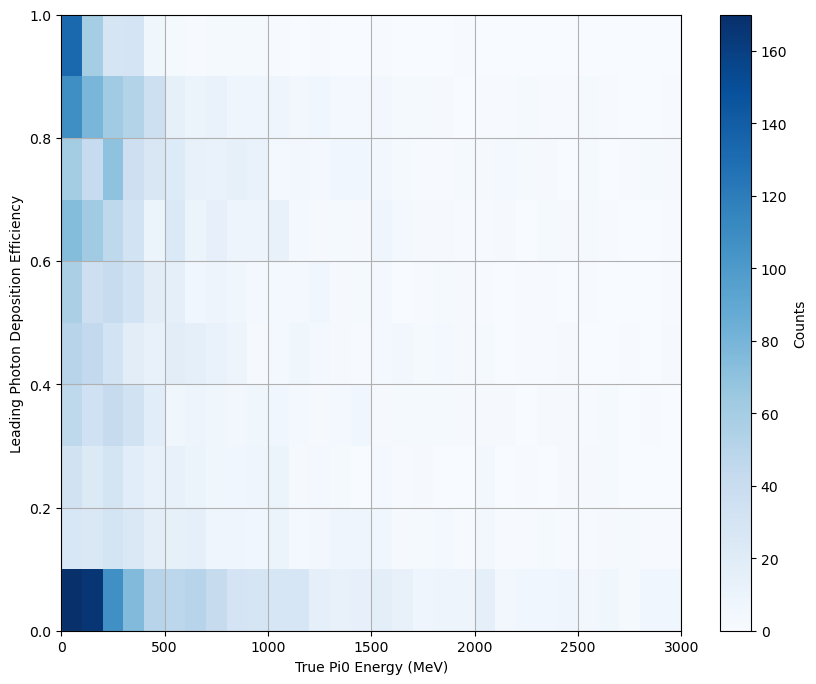

In [11]:
# 2D histogram of pi0 energy vs. lead depo efficiency
plt.figure(figsize=(10, 8))
plt.hist2d(containment_df["pi0_true_KE"], containment_df["lead_depo_efficiency"], bins=[energy_bins, eff_bins], cmap='Blues')
plt.colorbar(label='Counts')
plt.xlabel('True Pi0 Energy (MeV)')
plt.ylabel('Leading Photon Deposition Efficiency')
#plt.title('2D Histogram of Pi0 Energy vs. Lead Depo Efficiency')
plt.grid()
plt.show()

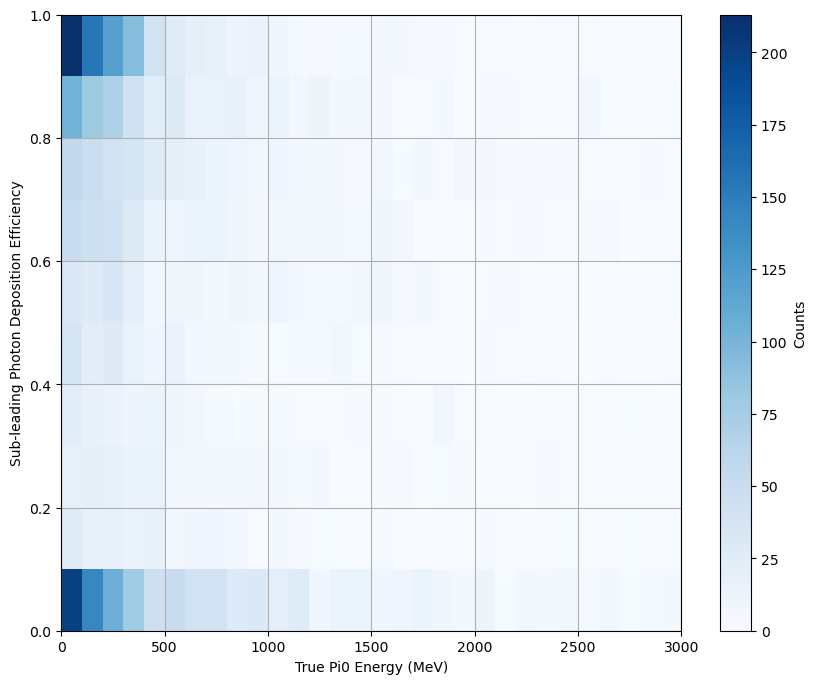

In [12]:
# 2D histogram of pi0 energy vs. sublead depo efficiency
plt.figure(figsize=(10, 8))
plt.hist2d(containment_df["pi0_true_KE"], containment_df["sublead_depo_efficiency"], bins=[energy_bins, eff_bins], cmap='Blues')
plt.colorbar(label='Counts')
plt.xlabel('True Pi0 Energy (MeV)')
plt.ylabel('Sub-leading Photon Deposition Efficiency')
#plt.title('2D Histogram of Pi0 Energy vs. Lead Depo Efficiency')
plt.grid()
plt.show()

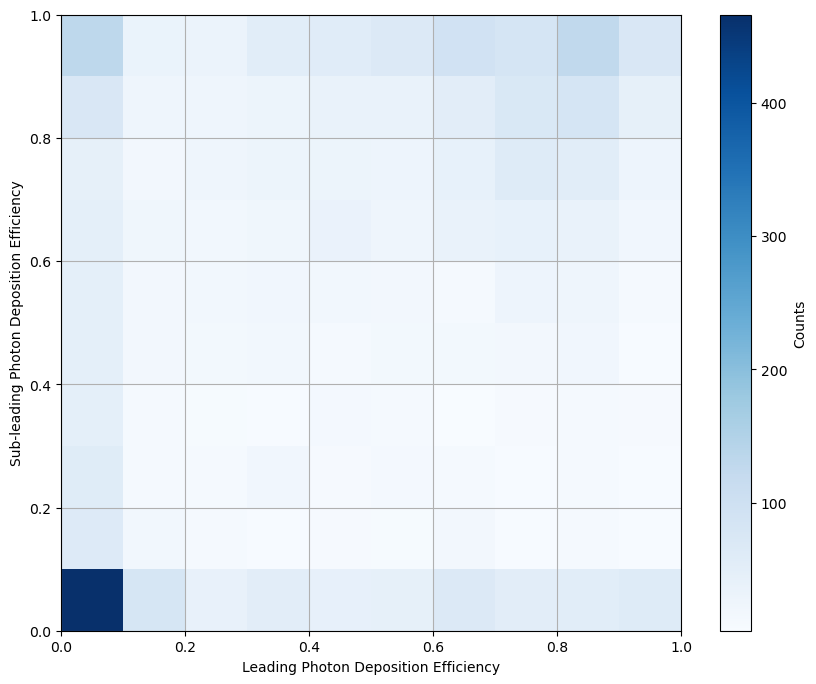

In [13]:
# 2D histogram of lead vs. sublead depo efficiency
plt.figure(figsize=(10, 8))
plt.hist2d(containment_df["lead_depo_efficiency"], containment_df["sublead_depo_efficiency"], bins=[eff_bins, eff_bins], cmap='Blues')
plt.colorbar(label='Counts')
plt.xlabel('Leading Photon Deposition Efficiency')
plt.ylabel('Sub-leading Photon Deposition Efficiency')
#plt.title('2D Histogram of Pi0 Energy vs. Lead Depo Efficiency')
plt.grid()
plt.show()

/tmp/ipykernel_1283497/3326929156.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for energy_bin, group in containment_df.groupby('pi0_KE_bin'):


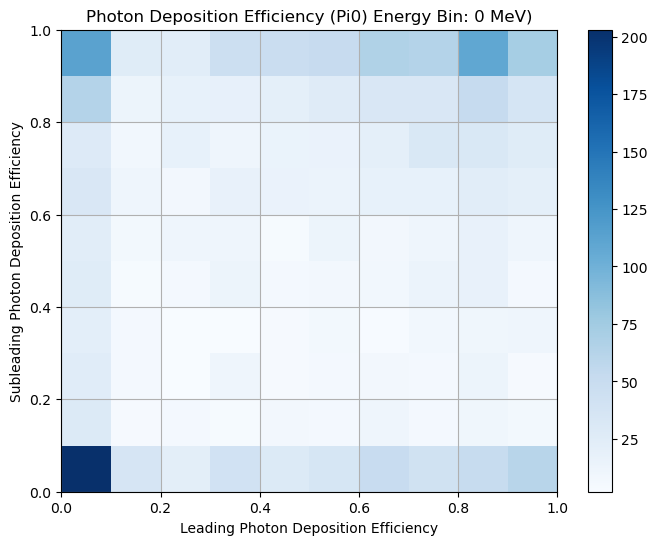

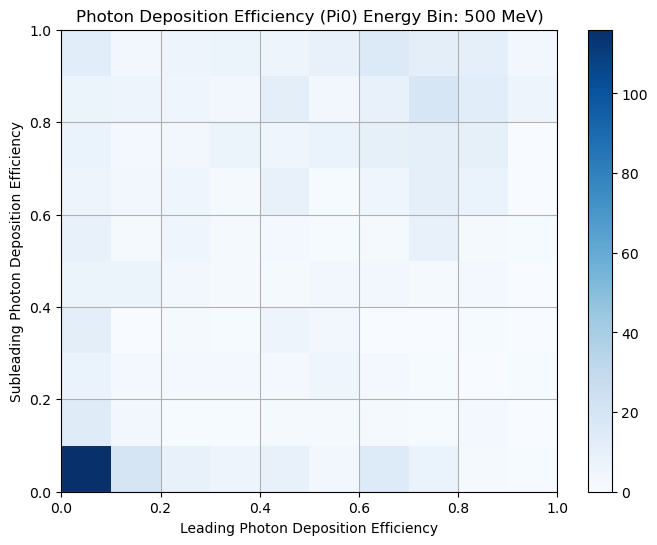

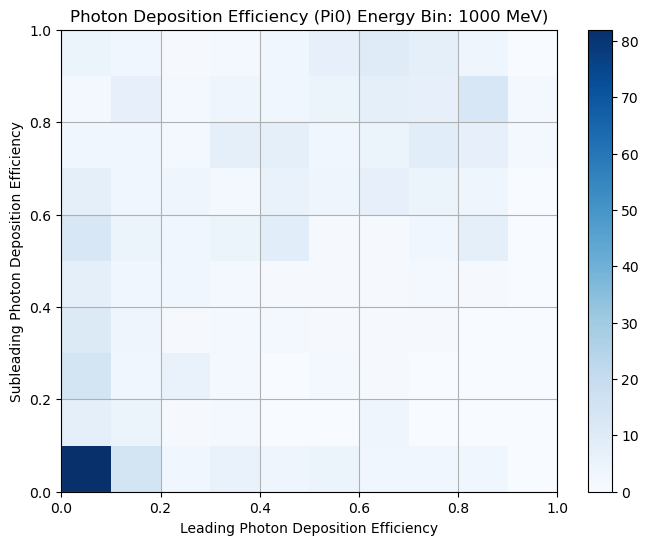

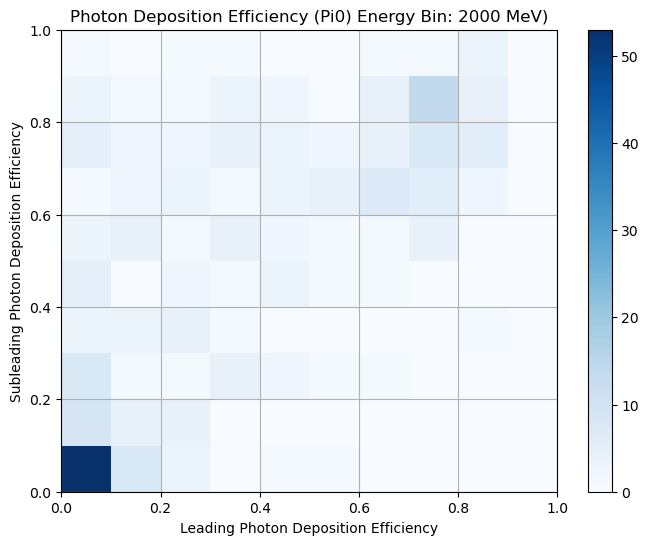

In [14]:

# GitHub Copilot suggestion for group of plots by energy
# Bin the data by energy
energy_bins = [0, 500, 1000, 2000, 5000]
containment_df['pi0_KE_bin'] = pd.cut(
    containment_df['pi0_true_KE'], bins=energy_bins, labels=energy_bins[:-1], include_lowest=True
)

# Iterate over each energy bin and plot
for energy_bin, group in containment_df.groupby('pi0_KE_bin'):
    if group.empty:
        continue  # Skip empty bins

    # Create scatter plot for the current energy bin
    plt.figure(figsize=(8, 6))
    plt.hist2d(
        group['lead_depo_efficiency'], 
        group['sublead_depo_efficiency'], bins=[eff_bins, eff_bins],
        cmap='Blues',
    )
    plt.xlabel('Leading Photon Deposition Efficiency')
    plt.ylabel('Subleading Photon Deposition Efficiency')
    plt.title(f'Photon Deposition Efficiency (Pi0) Energy Bin: {energy_bin} MeV)')
    plt.grid(True)
    plt.colorbar()
    plt.show()

In [15]:
# Filter by depo efficiency (leading and subleading > x %)

depo_energy_cut = 0.8
depo_containment_df = containment_df[containment_df["lead_depo_efficiency"] > depo_energy_cut]
depo_containment_df = depo_containment_df[depo_containment_df["sublead_depo_efficiency"] > depo_energy_cut]

print("Number of Events with Lead and Subleading Depo Efficiency > ", depo_energy_cut, ": ", len(depo_containment_df))

Number of Events with Lead and Subleading Depo Efficiency >  0.8 :  335


In [16]:
depo_energy_almost_okay = 0.7
depo_containment_df_almost_okay = containment_df[containment_df["lead_depo_efficiency"] > depo_energy_almost_okay]
depo_containment_df_almost_okay = depo_containment_df_almost_okay[depo_containment_df_almost_okay["sublead_depo_efficiency"] > depo_energy_almost_okay]
print("Number of Events with Lead and Subleading Depo Efficiency > ", depo_energy_almost_okay, ": ", len(depo_containment_df_almost_okay))

Number of Events with Lead and Subleading Depo Efficiency >  0.7 :  641


In [17]:
# Get just good reco events

# No reco or module gap issues
good_reco_high_depo_events = {"140093-1404000029",
                              "198151-1987000051",
                              "215032-2151000054",
                              "246182-2469000006",
                              "251126-2516000060",
                              "27136-276000052",
                              "297078-2974000027",
                              "34088-344000076",
                              "384143-3847000038",
                              "407000-4070000003",
                              "426130-4266000044",
                              "518168-5188000046",
                              "535056-5353000020",
                              "563065-5633000027",
                              "591033-5911000062",
                              "596050-5962000029",
                              "600147-6007000049",
                              "632175-6328000003",
                              "740181-7409000021",
                              "741078-7414000013",
                              "754024-7541000012",
                              "805137-8056000060",
                              "813036-8131000085",
                              "831150-8317000046",
                              "879189-8799000051",
                              "954146-9547000036"}

good_reco_high_depo_events_df = depo_containment_df[depo_containment_df["truth_dict_key"].isin(good_reco_high_depo_events)]
print("Number of Events with Lead and Subleading Depo Efficiency > ", depo_energy_cut, "and good reco: ", len(good_reco_high_depo_events_df))

Number of Events with Lead and Subleading Depo Efficiency >  0.8 and good reco:  26


Invariant Mass Bins:  [  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100. 110. 120. 130.
 140. 150. 160. 170. 180. 190. 200. 210. 220. 230. 240. 250. 260. 270.
 280. 290. 300. 310. 320. 330. 340. 350. 360. 370. 380. 390. 400. 410.
 420. 430. 440. 450. 460. 470. 480. 490. 500.]
Reco Counts:  [0 0 0 0 0 0 0 0 2 5 8 4 4 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
Reco M: 254      82.223876
487     112.231015
552     110.941347
684     123.273690
706     131.161010
800      93.786522
902      96.725955
1083     81.147017
1272    104.284434
1353    124.222862
1435     98.910166
1789    107.388082
1863    108.997354
1991    101.098037
2106    100.216598
2131    113.738083
2153    105.444014
2294     92.483979
2733    125.722327
2738    111.210650
2796    102.344316
2997    105.414854
3021     97.638746
3088    134.544224
3306    126.721059
3601           NaN
Name: diphoton_invariant_mass_from_reco, dtype: float64


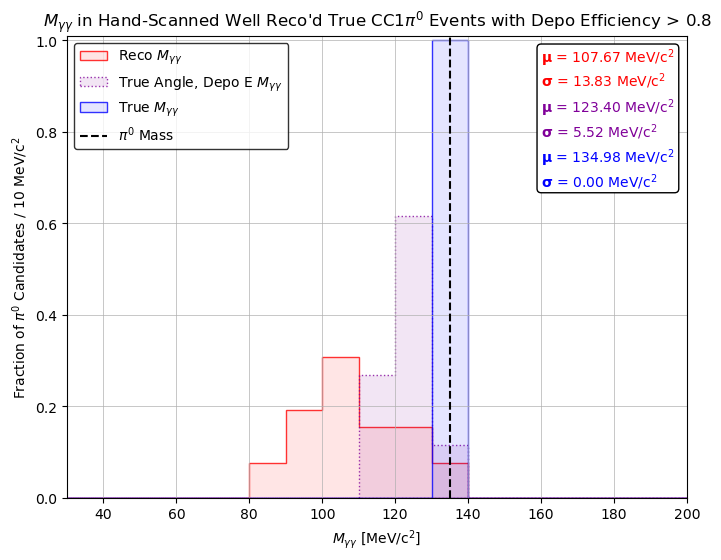

Reco Counts:  [ 0  3  0  3  2  0  4  6 17 49 68 46 31  7  5  0  1  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]
Reco M: 0        89.816424
38      107.883991
40      104.299159
42      112.360020
68      110.168058
           ...    
3733    101.638347
3743    109.034933
3762           NaN
3766    105.650629
3789    104.975939
Name: diphoton_invariant_mass_from_reco, Length: 335, dtype: float64


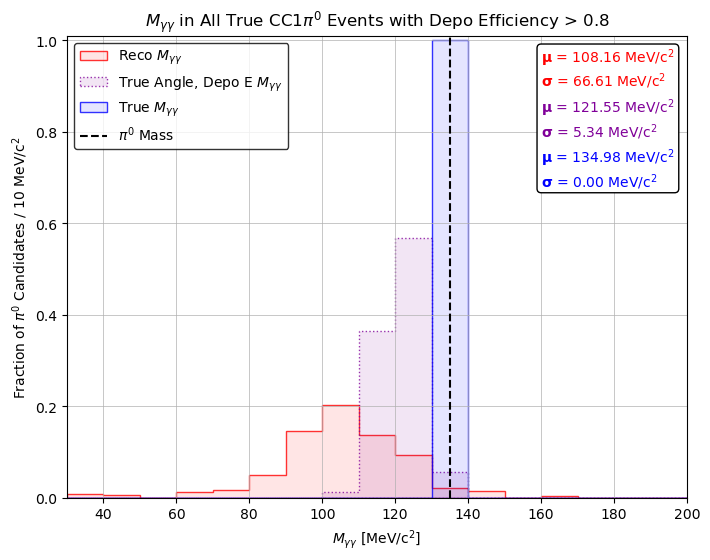

In [18]:
# Make invariant mass histogram: 
m_bins = np.linspace(0, 500, 51) # 20 MeV bins
m_bins_size = 10
print("Invariant Mass Bins: ", m_bins)

def make_inv_mass_plot_from_df(df, mbins, bin_size, sample):

    num_events = len(df)
    plt.figure(figsize=(8,6))
    ax = plt.gca()
    reco_counts, reco_bins = np.histogram(df["diphoton_invariant_mass_from_reco"], bins=mbins)
    print("Reco Counts: ", reco_counts)
    print("Reco M:", df['diphoton_invariant_mass_from_reco'])
    reco_mean = np.mean(df["diphoton_invariant_mass_from_reco"])
    reco_std = np.std(df["diphoton_invariant_mass_from_reco"])
    true_depo_counts, true_depo_bins = np.histogram(df["diphoton_invariant_mass_from_truth_depo_E"], bins=mbins)
    true_depo_mean = np.mean(df["diphoton_invariant_mass_from_truth_depo_E"])
    true_depo_std = np.std(df["diphoton_invariant_mass_from_truth_depo_E"])
    true_available_counts, true_available_bins = np.histogram(df["diphoton_invariant_mass_from_truth_available_E"], bins=mbins)
    true_available_mean = np.mean(df["diphoton_invariant_mass_from_truth_available_E"])
    true_available_std = np.std(df["diphoton_invariant_mass_from_truth_available_E"])
    plt.hist(reco_bins[:-1], bins=mbins, weights=reco_counts/num_events, histtype='stepfilled', \
             edgecolor=(1,0,0,0.8), linestyle='-', linewidth=1, label=r'Reco $M_{\gamma\gamma}$', color=(1,0,0,0.1))
    plt.hist(true_depo_bins[:-1], bins=mbins, weights=true_depo_counts/num_events, histtype='stepfilled', \
             edgecolor=(0.5,0,0.6,0.8), linestyle='dotted', linewidth=1, label=r'True Angle, Depo E $M_{\gamma\gamma}$', color=(0.5,0,0.6,0.1))
    plt.hist(true_available_bins[:-1], bins=mbins, weights=true_available_counts/num_events, histtype='stepfilled', \
             edgecolor=(0,0,1,0.8), linestyle='-', linewidth=1, label=r'True $M_{\gamma\gamma}$', color=(0,0,1,0.1))
    plt.xlabel(r'$M_{\gamma\gamma}$ [MeV/c$^2$]')
    plt.vlines([135], ymin=0, ymax=10, color='black', linestyle='--', label=r'$\pi^0$ Mass')
    reco_mean_text = r"$\mathbf{\mu}$ = %.2f MeV/c$^2$" % (reco_mean) 
    reco_std_text = r'$\mathbf{\sigma}$ = %.2f MeV/c$^2$' % (reco_std)
    reco_stats_text = reco_mean_text + '\n' + reco_std_text
    true_depo_mean_text = r'$\mathbf{\mu}$ = %.2f MeV/c$^2$' % (true_depo_mean)
    true_depo_std_text = r'$\mathbf{\sigma}$ = %.2f MeV/c$^2$' % (true_depo_std)
    true_depo_stats_text = true_depo_mean_text + '\n' + true_depo_std_text
    true_available_mean_text = r'$\mathbf{\mu}$ = %.2f MeV/c$^2$' % (true_available_mean)
    true_available_std_text = r'$\mathbf{\sigma}$ = %.2f MeV/c$^2$' % (true_available_std)
    true_available_stats_text = true_available_mean_text + '\n' + true_available_std_text
    all_stats_text = reco_stats_text + '\n' + true_depo_stats_text + '\n' + true_available_stats_text
    text_box_style = dict(boxstyle='round', facecolor='white', edgecolor='black')
    plt.text(
        0.98, 0.97, all_stats_text,
        transform=ax.transAxes,
        fontsize=10,
        color='white',
        verticalalignment='top',
        horizontalalignment='right',
        bbox=text_box_style
    )
    plt.text(160, 0.90, reco_stats_text, fontsize=10, color=(1,0,0,1))
    plt.text(160, 0.79, true_depo_stats_text, fontsize=10, color=(0.5,0,0.6,1))
    plt.text(160, 0.68, true_available_stats_text, fontsize=10, color=(0,0,1,1))
    plt.ylabel(r'Fraction of $\pi^0$ Candidates / '+str(bin_size)+' MeV/c$^2$')
    plt.title(r'$M_{\gamma\gamma}$ in ' + sample)
    plt.xlim(30, 200)
    plt.ylim(0, 1.01)
    plt.legend(facecolor='white', edgecolor='black', fontsize=10, loc='upper left')
    plt.grid(linewidth=0.5)
    plt.show()

make_inv_mass_plot_from_df(good_reco_high_depo_events_df, m_bins, m_bins_size, "Hand-Scanned Well Reco'd True CC1$\pi^0$ Events with Depo Efficiency > "+str(depo_energy_cut))
make_inv_mass_plot_from_df(depo_containment_df, m_bins, m_bins_size, "All True CC1$\pi^0$ Events with Depo Efficiency > "+str(depo_energy_cut))

Invariant Mass Bins:  [  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100. 110. 120. 130.
 140. 150. 160. 170. 180. 190. 200. 210. 220. 230. 240. 250. 260. 270.
 280. 290. 300. 310. 320. 330. 340. 350. 360. 370. 380. 390. 400. 410.
 420. 430. 440. 450. 460. 470. 480. 490. 500.]
Reco Counts:  0.9615384615384617


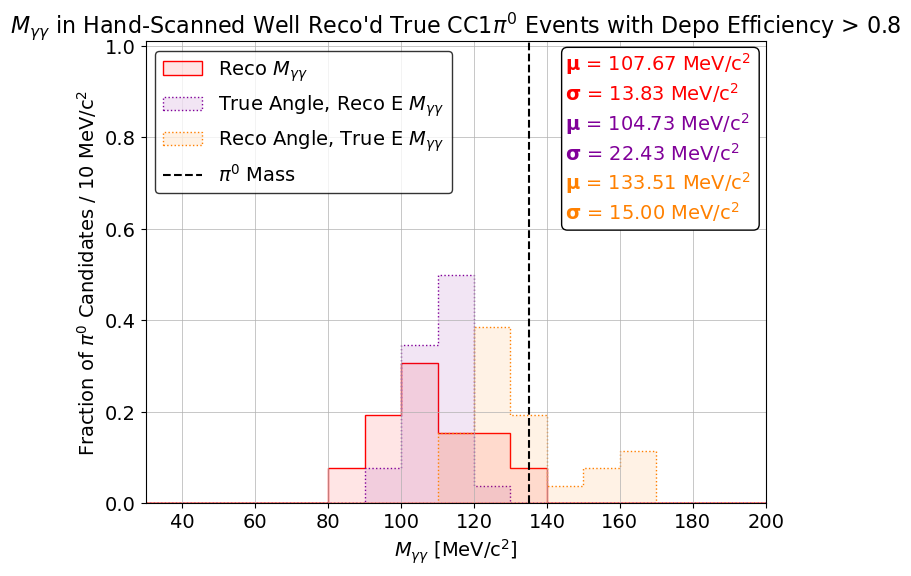

Reco Counts:  0.7223880597014926


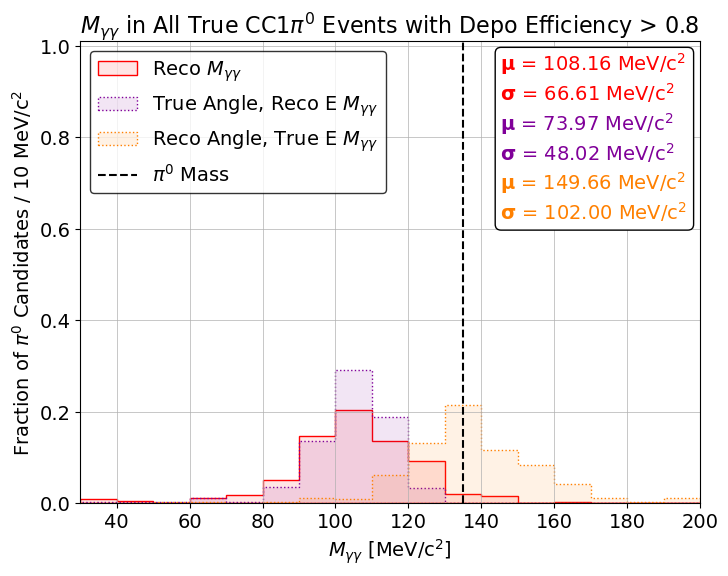

In [26]:
# Make invariant mass histogram reco, true swap: 
m_bins = np.linspace(0, 500, 51) # 20 MeV bins
m_bins_size = 10
print("Invariant Mass Bins: ", m_bins)

def make_inv_mass_plot_reco_true_mix_from_df(df, mbins, bin_size, sample):

    num_events = len(df)
    plt.figure(figsize=(8,6))
    ax = plt.gca()
    reco_counts, reco_bins = np.histogram(df["diphoton_invariant_mass_from_reco"], bins=mbins)
    print("Reco Counts: ", np.sum(reco_counts/num_events))
    reco_mean = np.mean(df["diphoton_invariant_mass_from_reco"])
    reco_std = np.std(df["diphoton_invariant_mass_from_reco"])
    true_angle_counts, true_angle_bins = np.histogram(df["diphoton_invariant_mass_true_angle_reco_energy"], bins=mbins)
    true_angle_mean = np.mean(df["diphoton_invariant_mass_true_angle_reco_energy"])
    true_angle_std = np.std(df["diphoton_invariant_mass_true_angle_reco_energy"])
    true_energy_counts, true_energy_bins = np.histogram(df["diphoton_invariant_mass_reco_angle_true_energy"], bins=mbins)
    true_energy_mean = np.mean(df["diphoton_invariant_mass_reco_angle_true_energy"])
    true_energy_std = np.std(df["diphoton_invariant_mass_reco_angle_true_energy"])
    plt.hist(reco_bins[:-1], bins=mbins, weights=reco_counts/num_events, histtype='stepfilled', \
             edgecolor=(1,0,0,1), linestyle='-', linewidth=1, label=r'Reco $M_{\gamma\gamma}$', color=(1,0,0,0.1))
    plt.hist(true_angle_bins[:-1], bins=mbins, weights=true_angle_counts/num_events, histtype='stepfilled', \
             edgecolor=(0.5,0,0.6,1), linestyle='dotted', linewidth=1, label=r'True Angle, Reco E $M_{\gamma\gamma}$', color=(0.5,0,0.6,0.1))
    plt.hist(true_energy_bins[:-1], bins=mbins, weights=true_energy_counts/num_events, histtype='stepfilled', \
             edgecolor=(1,0.5,0.0,1), linestyle='dotted', linewidth=1, label=r'Reco Angle, True E $M_{\gamma\gamma}$', color=(1,0.5,0,0.1))
    plt.xlabel(r'$M_{\gamma\gamma}$ [MeV/c$^2$]', fontsize=14)
    plt.vlines([135], ymin=0, ymax=10, color='black', linestyle='--', label=r'$\pi^0$ Mass')
    reco_mean_text = r"$\mathbf{\mu}$ = %.2f MeV/c$^2$" % (reco_mean) 
    reco_std_text = r'$\mathbf{\sigma}$ = %.2f MeV/c$^2$' % (reco_std)
    reco_stats_text = reco_mean_text + '\n' + reco_std_text
    true_angle_mean_text = r'$\mathbf{\mu}$ = %.2f MeV/c$^2$' % (true_angle_mean)
    true_angle_std_text = r'$\mathbf{\sigma}$ = %.2f MeV/c$^2$' % (true_angle_std)
    true_angle_stats_text = true_angle_mean_text + '\n' + true_angle_std_text
    true_energy_mean_text = r'$\mathbf{\mu}$ = %.2f MeV/c$^2$' % (true_energy_mean)
    true_energy_std_text = r'$\mathbf{\sigma}$ = %.2f MeV/c$^2$' % (true_energy_std)
    true_energy_stats_text = true_energy_mean_text + '\n' + true_energy_std_text
    all_stats_text = reco_stats_text + '\n' + true_angle_stats_text + '\n' + true_energy_stats_text
    text_box_style = dict(boxstyle='round', facecolor='white', edgecolor='black')
    plt.text(
        0.98, 0.97, all_stats_text,
        transform=ax.transAxes,
        fontsize=14,
        color='white',
        verticalalignment='top',
        horizontalalignment='right',
        bbox=text_box_style
    )
    plt.text(145, 0.88, reco_stats_text, fontsize=14, color=(1,0,0,1))
    plt.text(145, 0.75, true_angle_stats_text, fontsize=14, color=(0.5,0,0.6,1))
    plt.text(145, 0.62, true_energy_stats_text, fontsize=14, color=(1,0.5,0,1))
    ax = plt.gca()
    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)
    plt.ylabel(r'Fraction of $\pi^0$ Candidates / '+str(bin_size)+' MeV/c$^2$', fontsize=14)
    plt.title(r'$M_{\gamma\gamma}$ in ' + sample, fontsize=16)
    plt.xlim(30, 200)
    plt.ylim(0, 1.01)
    plt.legend(facecolor='white', edgecolor='black', fontsize=14, loc='upper left')
    plt.grid(linewidth=0.5)
    plt.show()

make_inv_mass_plot_reco_true_mix_from_df(good_reco_high_depo_events_df, m_bins, m_bins_size, "Hand-Scanned Well Reco'd True CC1$\pi^0$ Events with Depo Efficiency > "+str(depo_energy_cut))
make_inv_mass_plot_reco_true_mix_from_df(depo_containment_df, m_bins, m_bins_size, "All True CC1$\pi^0$ Events with Depo Efficiency > "+str(depo_energy_cut))

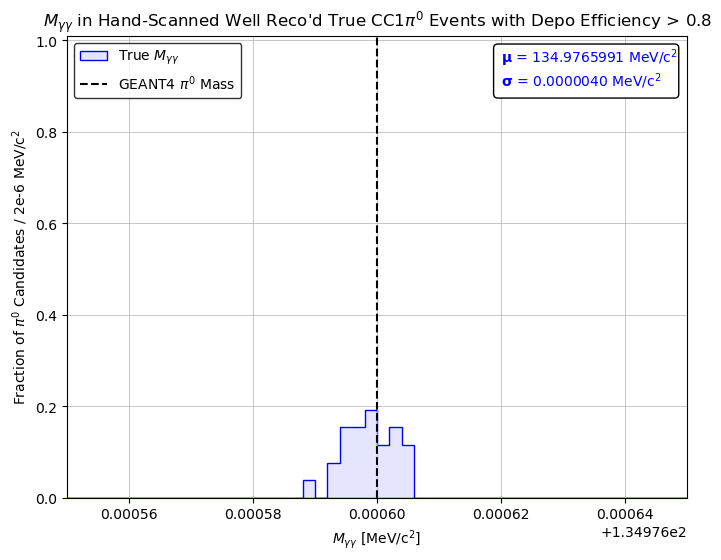

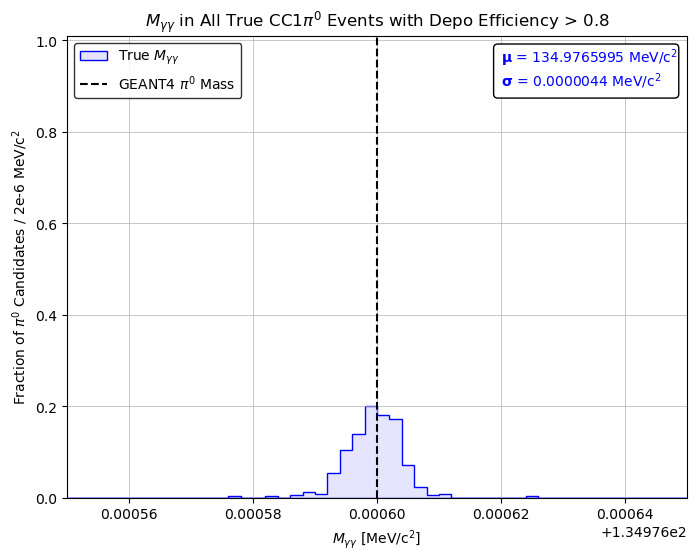

In [19]:
# Plot true invariant mass distribution 
true_bins = np.linspace(134.97655, 134.97665, 51) # 20 MeV bins
true_bins_size = r'2e-6'

def plot_true_inv_mass(df, mbins, bin_size, sample):

    num_events = len(df)
    plt.figure(figsize=(8,6))
    ax = plt.gca()
    true_counts, true_bins = np.histogram(df["diphoton_invariant_mass_from_truth_available_E"], bins=mbins)
    true_mean = np.mean(df["diphoton_invariant_mass_from_truth_available_E"])
    true_std = np.std(df["diphoton_invariant_mass_from_truth_available_E"])
    plt.hist(true_bins[:-1], bins=true_bins, weights=true_counts/num_events, histtype='stepfilled', \
             edgecolor=(0,0,1,1), linestyle='-', linewidth=1, label=r'True $M_{\gamma\gamma}$', color=(0,0,1,0.1))
    plt.xlabel(r'$M_{\gamma\gamma}$ [MeV/c$^2$]')
    plt.vlines([134.9766], ymin=0, ymax=10, color='black', linestyle='--', label=r'GEANT4 $\pi^0$ Mass')
    true_mean_text = r"$\mathbf{\mu}$ = %.7f MeV/c$^2$" % (true_mean) 
    true_std_text = r'$\mathbf{\sigma}$ = %.7f MeV/c$^2$' % (true_std)
    true_stats_text = true_mean_text + '\n' + true_std_text
    text_box_style = dict(boxstyle='round', facecolor='white', edgecolor='black')
    plt.text(
        0.98, 0.97, true_stats_text,
        transform=ax.transAxes,
        fontsize=10,
        color='white',
        verticalalignment='top',
        horizontalalignment='right',
        bbox=text_box_style
    )
    plt.text(134.97662, 0.90, true_stats_text, fontsize=10, color=(0,0,1,1))
    plt.ylabel(r'Fraction of $\pi^0$ Candidates / '+bin_size+' MeV/c$^2$')
    plt.title(r'$M_{\gamma\gamma}$ in ' + sample)
    plt.xlim(134.97655, 134.97665)
    plt.ylim(0, 1.01)
    plt.legend(facecolor='white', edgecolor='black', fontsize=10, loc='upper left')
    plt.grid(linewidth=0.5)
    plt.show()

plot_true_inv_mass(good_reco_high_depo_events_df, true_bins, true_bins_size, "Hand-Scanned Well Reco'd True CC1$\pi^0$ Events with Depo Efficiency > "+str(depo_energy_cut))
plot_true_inv_mass(depo_containment_df, true_bins, true_bins_size, "All True CC1$\pi^0$ Events with Depo Efficiency > "+str(depo_energy_cut))

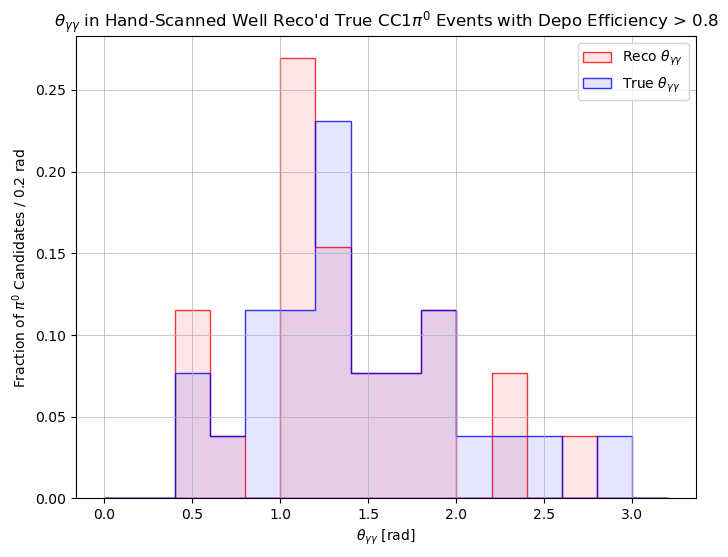

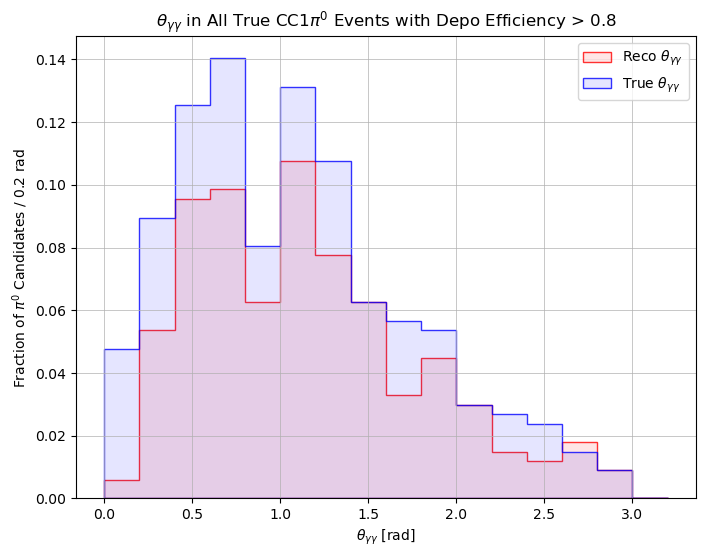

In [20]:
# Make shower angle histogram
angle_bins = np.linspace(0, 3.2, 17) # 20 MeV bins
angle_bins_size = 0.2

def make_shower_angle_plot_from_df(df, abins, bin_size, sample):

    num_events = len(df)
    plt.figure(figsize=(8,6))
    reco_counts, reco_bins = np.histogram(df["reco_shower_angle"], bins=abins)
    true_counts, true_bins = np.histogram(df["true_shower_angle"], bins=abins)
    plt.hist(reco_bins[:-1], bins=abins, weights=reco_counts/num_events, histtype='stepfilled', \
             edgecolor=(1,0,0,0.8), linestyle='-', linewidth=1, label=r'Reco $\theta_{\gamma\gamma}$', color=(1,0,0,0.1))
    plt.hist(true_bins[:-1], bins=abins, weights=true_counts/num_events, histtype='stepfilled', \
             edgecolor=(0,0,1,0.8), linestyle='-', linewidth=1, label=r'True $\theta_{\gamma\gamma}$', color=(0,0,1,0.1))
    plt.xlabel(r'$\theta_{\gamma\gamma}$ [rad]')
    plt.ylabel(r'Fraction of $\pi^0$ Candidates / '+str(bin_size)+' rad')
    plt.title(r'$\theta_{\gamma\gamma}$ in ' + sample)
    #plt.xlim(30, 200)
    #plt.ylim(0, 1.01)
    plt.legend()
    plt.grid(linewidth=0.5) 
    plt.show()

make_shower_angle_plot_from_df(good_reco_high_depo_events_df, angle_bins, angle_bins_size, "Hand-Scanned Well Reco'd True CC1$\pi^0$ Events with Depo Efficiency > "+str(depo_energy_cut))
make_shower_angle_plot_from_df(depo_containment_df, angle_bins, angle_bins_size, "All True CC1$\pi^0$ Events with Depo Efficiency > "+str(depo_energy_cut))

/tmp/ipykernel_497789/3438145519.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['true_minus_reco_shower_angle'] = df['true_shower_angle_from_start_pts'] - df['reco_shower_angle_from_start_pts']
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


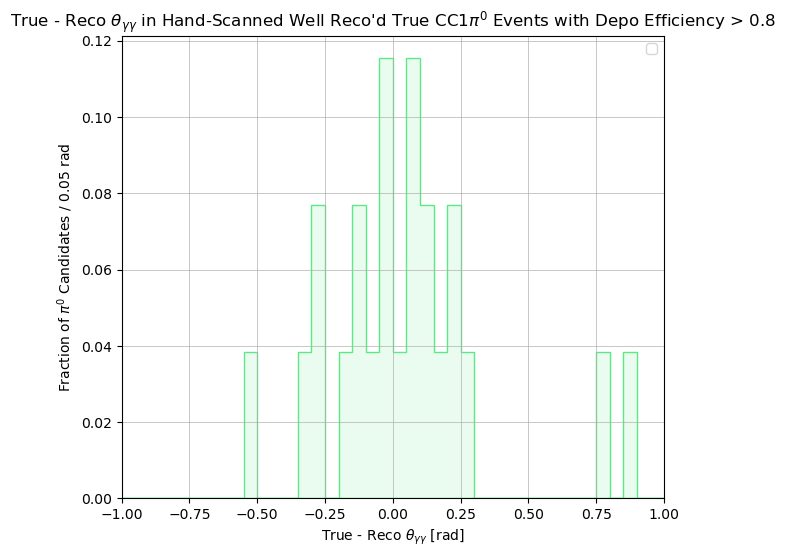

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


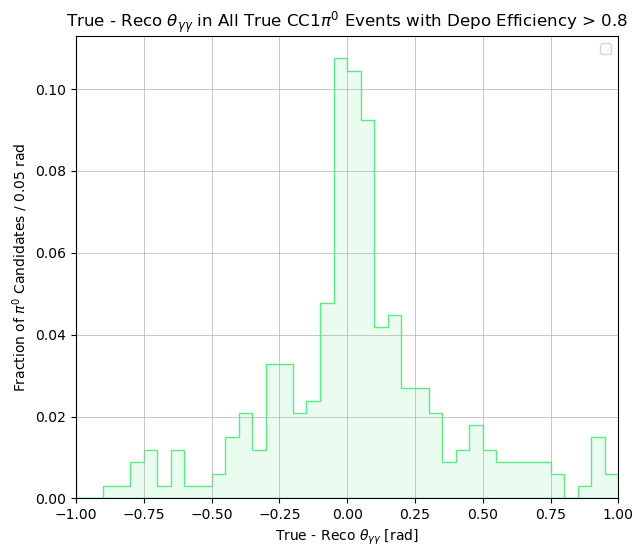

In [21]:
# Make shower angle difference histogram
angle_bins = np.linspace(-3.2, 3.2, 129) # 20 MeV bins
angle_bins_size = 0.05


def make_shower_angle_difference_plot_from_df(df, abins, bin_size, sample):

    num_events = len(df)
    df['true_minus_reco_shower_angle'] = df['true_shower_angle_from_start_pts'] - df['reco_shower_angle_from_start_pts']
    plt.figure(figsize=(7,6))
    diff_counts, diff_bins = np.histogram(df['true_minus_reco_shower_angle'], bins=abins)
    plt.hist(diff_bins[:-1], bins=abins, weights=diff_counts/num_events, histtype='stepfilled', \
             edgecolor=(0.2,0.9,0.4,0.8), linestyle='-', linewidth=1, color=(0.2,0.9,0.4,0.1))
    plt.xlabel(r'True - Reco $\theta_{\gamma\gamma}$ [rad]')
    plt.ylabel(r'Fraction of $\pi^0$ Candidates / '+str(bin_size)+' rad')
    plt.title(r'True - Reco $\theta_{\gamma\gamma}$ in ' + sample)
    #plt.xlim(-3.2, 3.2)
    plt.xlim(-1,1)
    #plt.ylim(0, 1.01)
    plt.legend()
    plt.grid(linewidth=0.5) 
    plt.show()

make_shower_angle_difference_plot_from_df(good_reco_high_depo_events_df, angle_bins, angle_bins_size, "Hand-Scanned Well Reco'd True CC1$\pi^0$ Events with Depo Efficiency > "+str(depo_energy_cut))
make_shower_angle_difference_plot_from_df(depo_containment_df, angle_bins, angle_bins_size, "All True CC1$\pi^0$ Events with Depo Efficiency > "+str(depo_energy_cut))

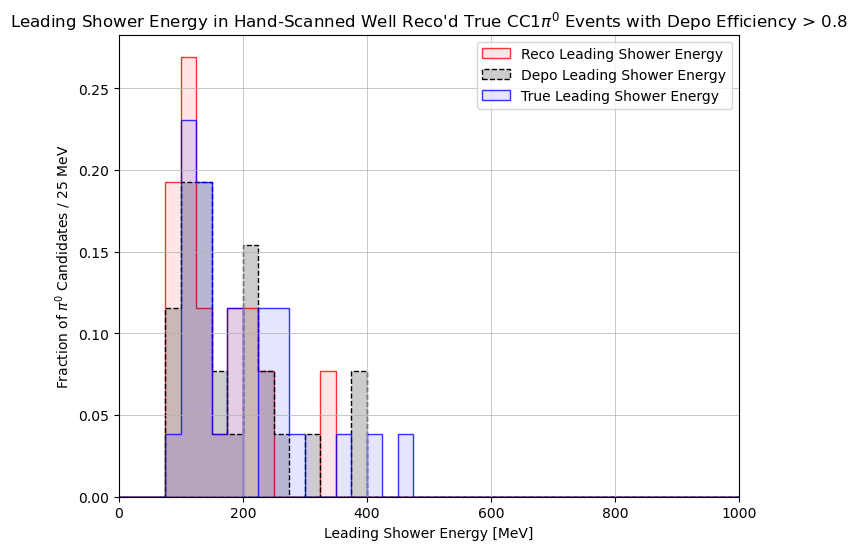

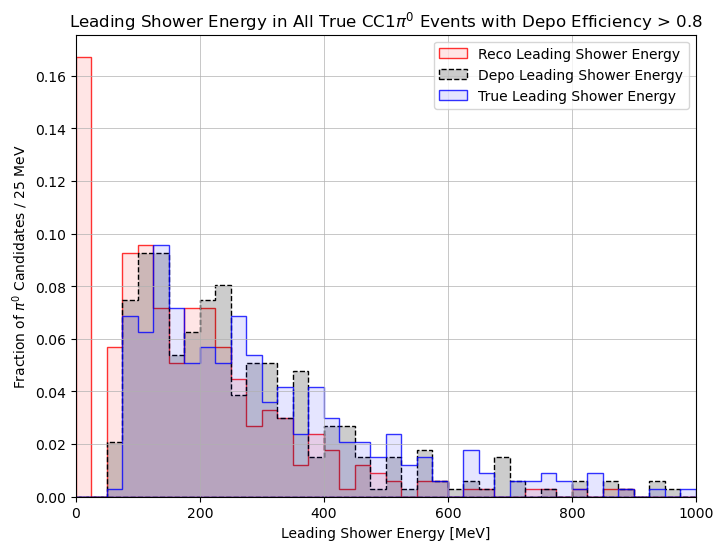

In [22]:
# Make leading shower energy histogram
energy_bins = np.linspace(0, 2000, 81) 
energy_bins_size = 25

def make_lead_energy_shower_plot_from_df(df, energy_bins, bin_size, sample):

    num_events = len(df)
    plt.figure(figsize=(8,6))
    reco_counts, reco_bins = np.histogram(df["lead_reco_E"], bins=energy_bins)
    depo_counts, depo_bins = np.histogram(df["lead_depo_E"], bins=energy_bins)
    true_counts, true_bins = np.histogram(df["lead_available_E"], bins=energy_bins)
    plt.hist(reco_bins[:-1], bins=energy_bins, weights=reco_counts/num_events, histtype='stepfilled', \
             edgecolor=(1,0,0,0.8), linestyle='-', linewidth=1, label=r'Reco Leading Shower Energy', color=(1,0,0,0.1))
    plt.hist(depo_bins[:-1], bins=energy_bins, weights=depo_counts/num_events, histtype='stepfilled', \
             edgecolor=(0.0,0.0,0.0,1), linestyle='--', linewidth=1, label=r'Depo Leading Shower Energy', color=(0.0,0.0,0.0,0.2))
    plt.hist(true_bins[:-1], bins=energy_bins, weights=true_counts/num_events, histtype='stepfilled', \
             edgecolor=(0,0,1,0.8), linestyle='-', linewidth=1, label=r'True Leading Shower Energy', color=(0,0,1,0.1))
    plt.xlabel('Leading Shower Energy [MeV]')
    plt.ylabel(r'Fraction of $\pi^0$ Candidates / '+str(bin_size)+' MeV')
    plt.title(r'Leading Shower Energy in ' + sample)
    plt.xlim(0, 1000)
    #plt.ylim(0, 1.01)
    plt.legend()
    plt.grid(linewidth=0.5) 
    plt.show()

make_lead_energy_shower_plot_from_df(good_reco_high_depo_events_df, energy_bins, energy_bins_size, "Hand-Scanned Well Reco'd True CC1$\pi^0$ Events with Depo Efficiency > "+str(depo_energy_cut))
make_lead_energy_shower_plot_from_df(depo_containment_df, energy_bins, energy_bins_size, "All True CC1$\pi^0$ Events with Depo Efficiency > "+str(depo_energy_cut))

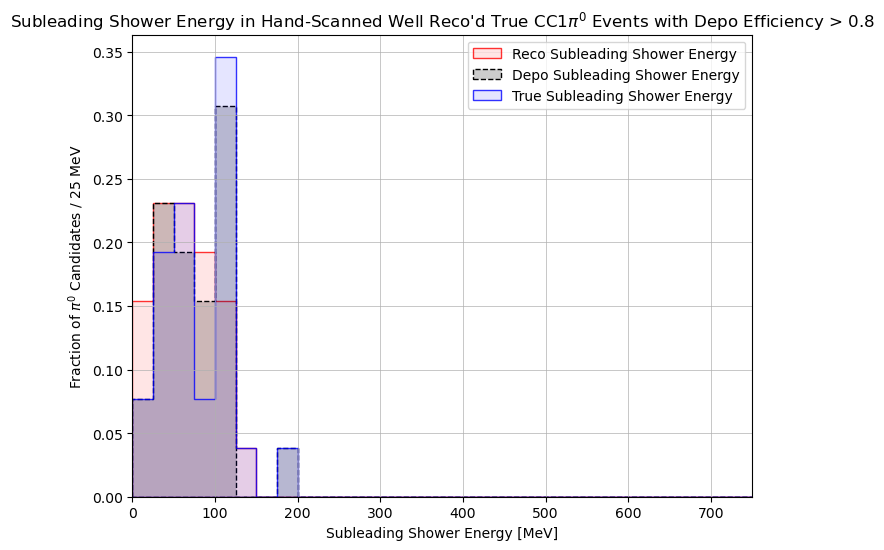

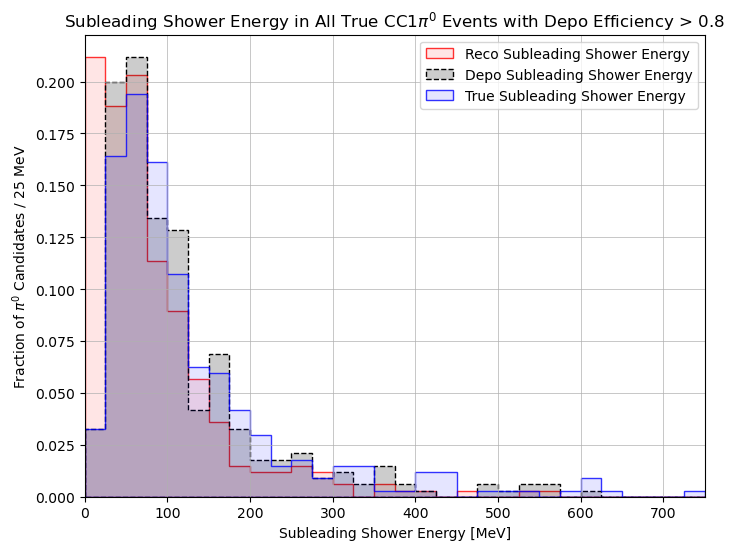

In [23]:
# Make subleading shower energy histogram
energy_bins = np.linspace(0, 2000, 81) 
energy_bins_size = 25

def make_sublead_energy_shower_plot_from_df(df, energy_bins, bin_size, sample):

    num_events = len(df)
    plt.figure(figsize=(8,6))
    reco_counts, reco_bins = np.histogram(df["sublead_reco_E"], bins=energy_bins)
    depo_counts, depo_bins = np.histogram(df["sublead_depo_E"], bins=energy_bins)
    true_counts, true_bins = np.histogram(df["sublead_available_E"], bins=energy_bins)
    plt.hist(reco_bins[:-1], bins=energy_bins, weights=reco_counts/num_events, histtype='stepfilled', \
             edgecolor=(1,0,0,0.8), linestyle='-', linewidth=1, label=r'Reco Subleading Shower Energy', color=(1,0,0,0.1))
    plt.hist(depo_bins[:-1], bins=energy_bins, weights=depo_counts/num_events, histtype='stepfilled', \
             edgecolor=(0.0,0.0,0.0,1), linestyle='--', linewidth=1, label=r'Depo Subleading Shower Energy', color=(0.0,0.0,0.0,0.2))
    plt.hist(true_bins[:-1], bins=energy_bins, weights=true_counts/num_events, histtype='stepfilled', \
             edgecolor=(0,0,1,0.8), linestyle='-', linewidth=1, label=r'True Subleading Shower Energy', color=(0,0,1,0.1))
    plt.xlabel('Subleading Shower Energy [MeV]')
    plt.ylabel(r'Fraction of $\pi^0$ Candidates / '+str(bin_size)+' MeV')
    plt.title(r'Subleading Shower Energy in ' + sample)
    plt.xlim(0, 750)
    #plt.ylim(0, 1.01)
    plt.legend()
    plt.grid(linewidth=0.5) 
    plt.show()

make_sublead_energy_shower_plot_from_df(good_reco_high_depo_events_df, energy_bins, energy_bins_size, "Hand-Scanned Well Reco'd True CC1$\pi^0$ Events with Depo Efficiency > "+str(depo_energy_cut))
make_sublead_energy_shower_plot_from_df(depo_containment_df, energy_bins, energy_bins_size, "All True CC1$\pi^0$ Events with Depo Efficiency > "+str(depo_energy_cut))

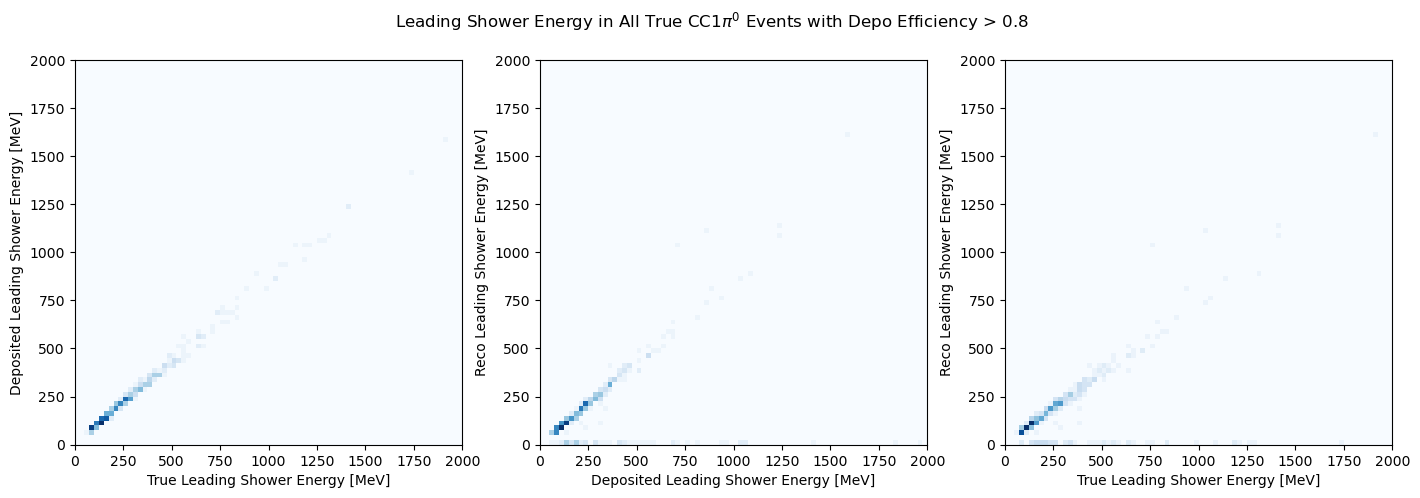

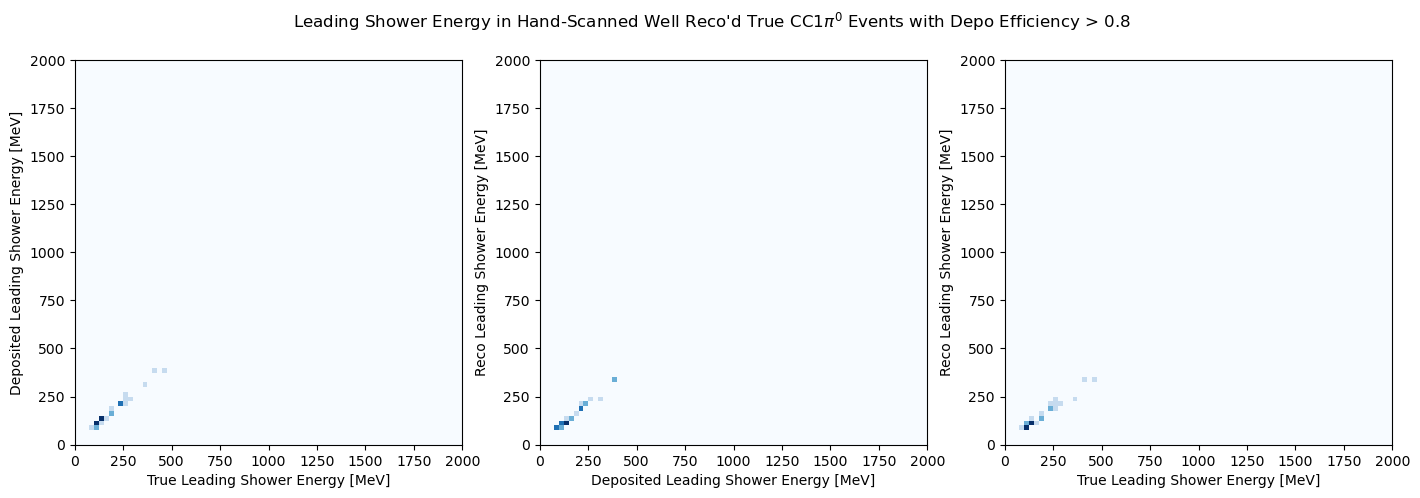

In [24]:
# Make leading shower 2D energy histogram
energy_bins = np.linspace(0, 2000, 81) 
energy_bins_size = 25

def make_lead_energy_shower_2D_plots_from_df(df, energy_bins, bin_size, sample):

    num_events = len(df)
    fig, ax = plt.subplots(1,3,figsize=(17,5))
    reco_counts, reco_bins = np.histogram(df["lead_reco_E"], bins=energy_bins)
    depo_counts, depo_bins = np.histogram(df["lead_depo_E"], bins=energy_bins)
    true_counts, true_bins = np.histogram(df["lead_available_E"], bins=energy_bins)
    ax[0].hist2d(df["lead_available_E"], df["lead_depo_E"], bins=[energy_bins, energy_bins], cmap='Blues')
    ax[0].set_xlabel('True Leading Shower Energy [MeV]')
    ax[0].set_ylabel('Deposited Leading Shower Energy [MeV]')

    ax[1].hist2d(df["lead_depo_E"], df["lead_reco_E"], bins=[energy_bins, energy_bins], cmap='Blues')
    ax[1].set_xlabel('Deposited Leading Shower Energy [MeV]')
    ax[1].set_ylabel('Reco Leading Shower Energy [MeV]')

    ax[2].hist2d(df["lead_available_E"], df["lead_reco_E"], bins=[energy_bins, energy_bins], cmap='Blues')
    ax[2].set_xlabel('True Leading Shower Energy [MeV]')
    ax[2].set_ylabel('Reco Leading Shower Energy [MeV]')

    fig.suptitle(r'Leading Shower Energy in ' + sample)

    #plt.colorbar(label='Counts')

    plt.show()

make_lead_energy_shower_2D_plots_from_df(depo_containment_df, energy_bins, energy_bins_size, "All True CC1$\pi^0$ Events with Depo Efficiency > "+str(depo_energy_cut))
make_lead_energy_shower_2D_plots_from_df(good_reco_high_depo_events_df, energy_bins, energy_bins_size, "Hand-Scanned Well Reco'd True CC1$\pi^0$ Events with Depo Efficiency > "+str(depo_energy_cut))


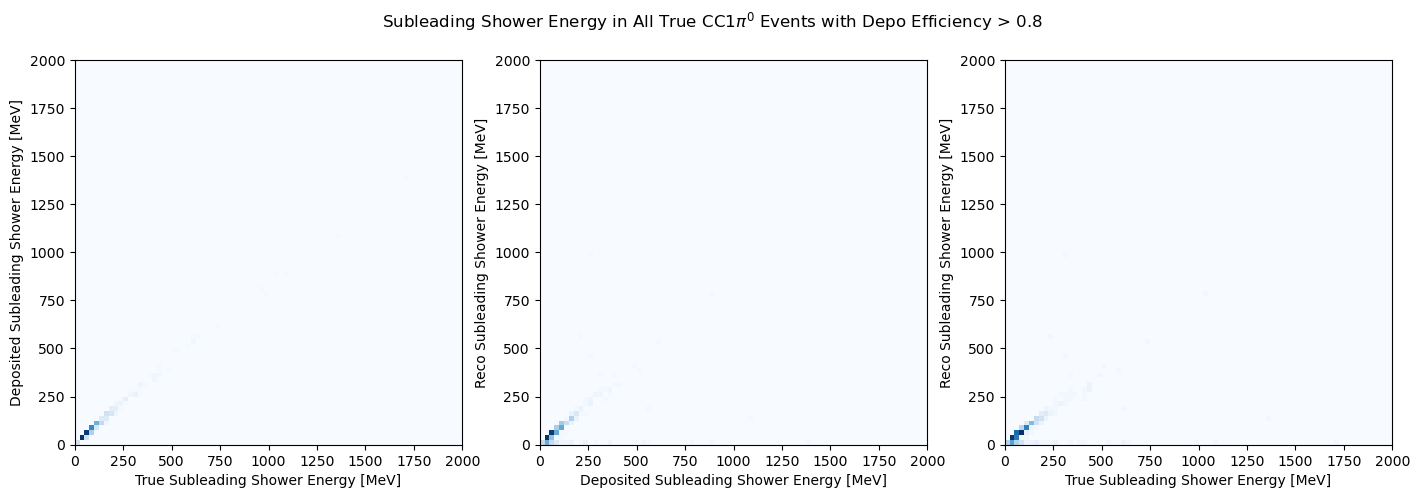

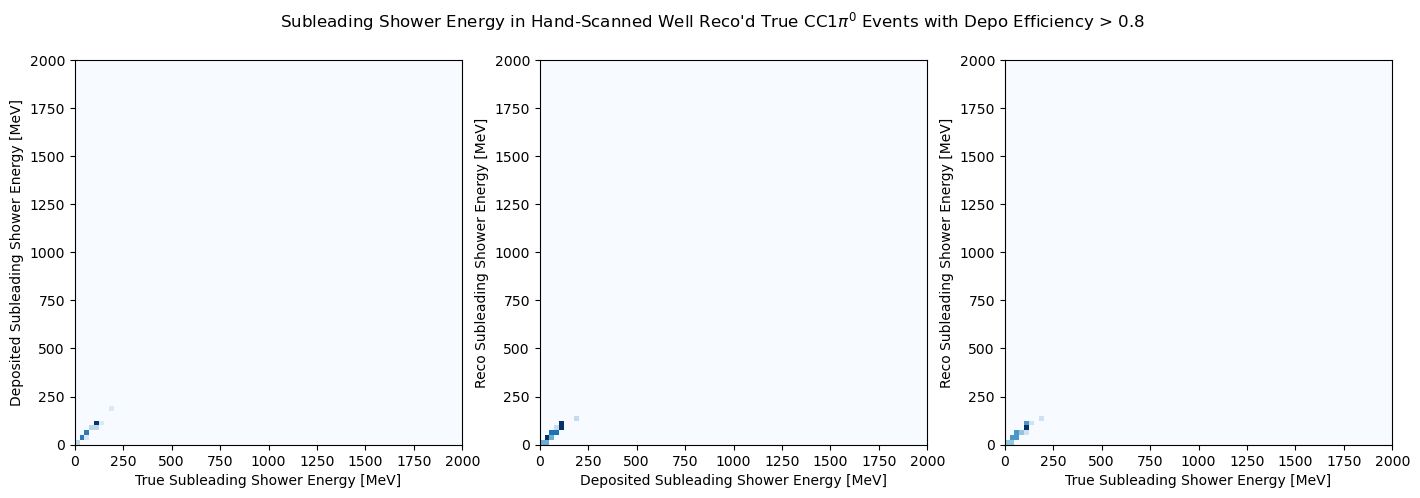

In [25]:
# Make leading shower 2D energy histogram
energy_bins = np.linspace(0, 2000, 81) 
energy_bins_size = 25

def make_sublead_energy_shower_2D_plots_from_df(df, energy_bins, bin_size, sample):

    num_events = len(df)
    fig, ax = plt.subplots(1,3,figsize=(17,5))
    reco_counts, reco_bins = np.histogram(df["sublead_reco_E"], bins=energy_bins)
    depo_counts, depo_bins = np.histogram(df["sublead_depo_E"], bins=energy_bins)
    true_counts, true_bins = np.histogram(df["sublead_available_E"], bins=energy_bins)
    ax[0].hist2d(df["sublead_available_E"], df["sublead_depo_E"], bins=[energy_bins, energy_bins], cmap='Blues')
    ax[0].set_xlabel('True Subleading Shower Energy [MeV]')
    ax[0].set_ylabel('Deposited Subleading Shower Energy [MeV]')

    ax[1].hist2d(df["sublead_depo_E"], df["sublead_reco_E"], bins=[energy_bins, energy_bins], cmap='Blues')
    ax[1].set_xlabel('Deposited Subleading Shower Energy [MeV]')
    ax[1].set_ylabel('Reco Subleading Shower Energy [MeV]')

    ax[2].hist2d(df["sublead_available_E"], df["sublead_reco_E"], bins=[energy_bins, energy_bins], cmap='Blues')
    ax[2].set_xlabel('True Subleading Shower Energy [MeV]')
    ax[2].set_ylabel('Reco Subleading Shower Energy [MeV]')

    fig.suptitle(r'Subleading Shower Energy in ' + sample)

    #plt.colorbar(label='Counts')

    plt.show()

make_sublead_energy_shower_2D_plots_from_df(depo_containment_df, energy_bins, energy_bins_size, "All True CC1$\pi^0$ Events with Depo Efficiency > "+str(depo_energy_cut))
make_sublead_energy_shower_2D_plots_from_df(good_reco_high_depo_events_df, energy_bins, energy_bins_size, "Hand-Scanned Well Reco'd True CC1$\pi^0$ Events with Depo Efficiency > "+str(depo_energy_cut))


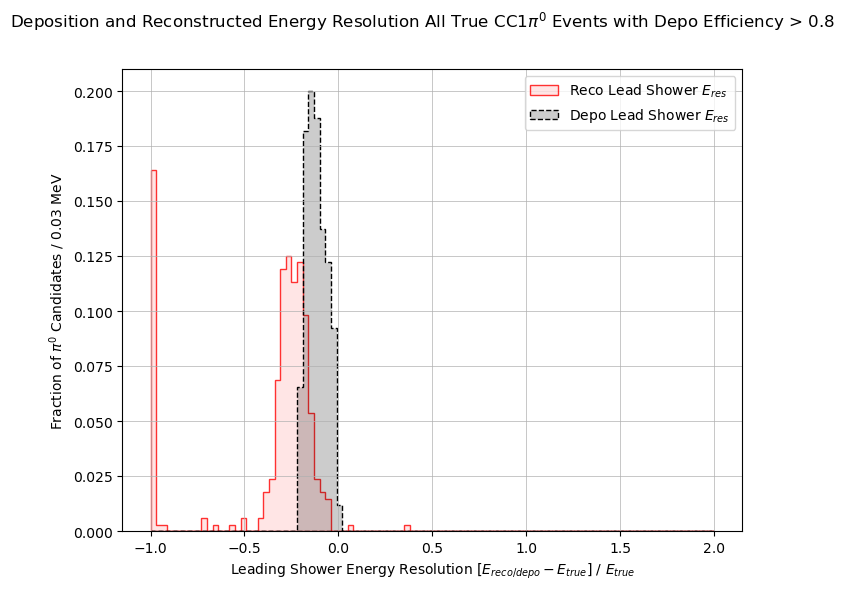

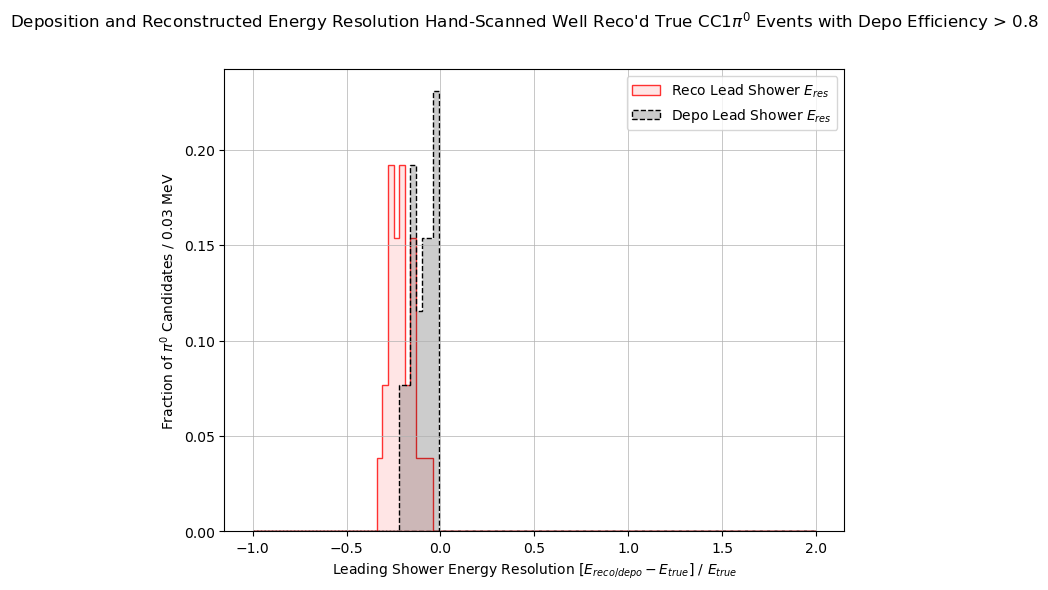

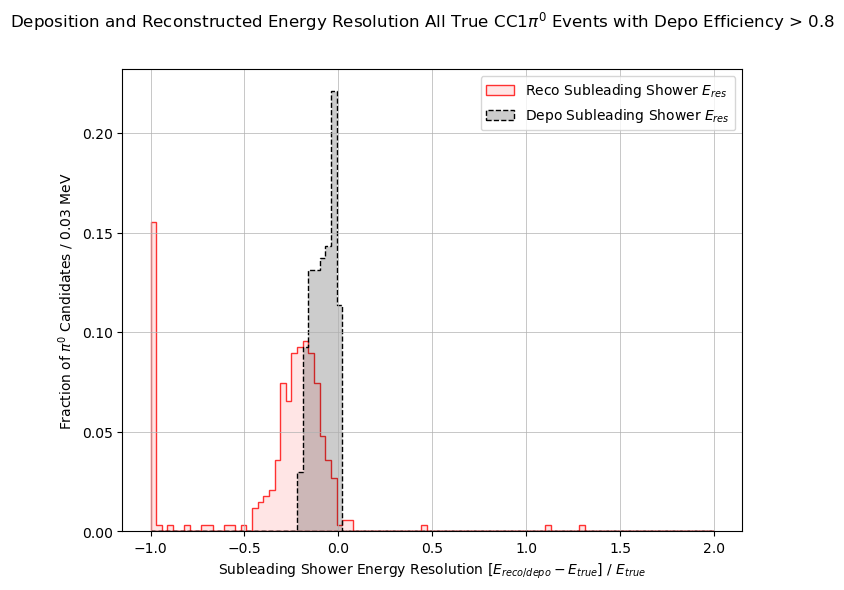

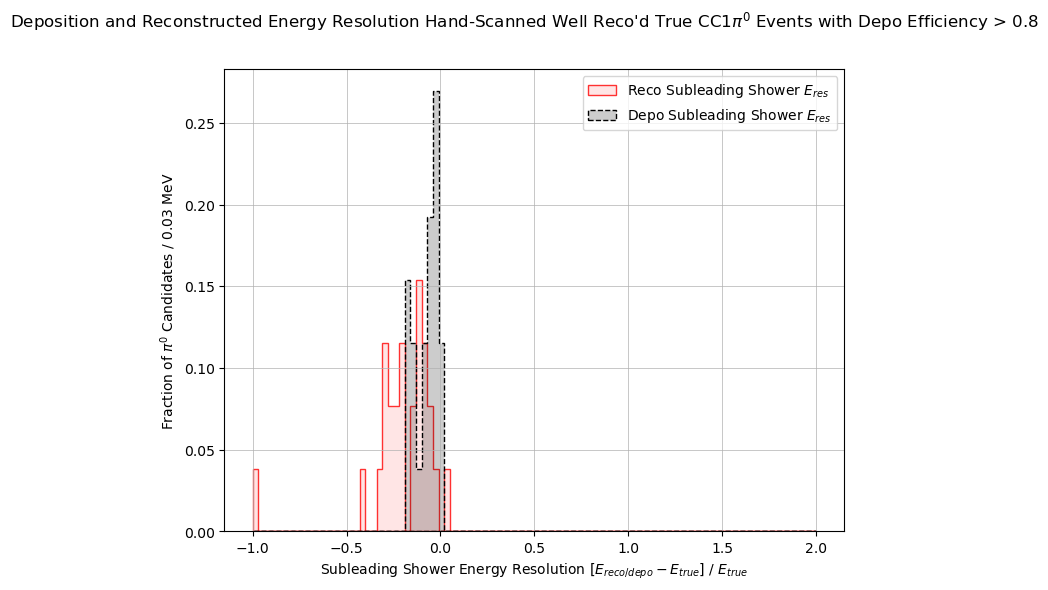

In [26]:
# Make leading shower energy resolution plots
energy_res_bins = np.linspace(-1,2, 101) 
energy_res_bins_size = 0.03
def make_lead_energy_shower_energy_res_plots_from_df(df, energy_bins, bin_size, sample):

    num_events = len(df)
    fig, ax = plt.subplots(1,1,figsize=(8,6))
    reco_res_counts, reco_res_bins = np.histogram(((df["lead_reco_E"]-df["lead_available_E"])/df["lead_available_E"]), bins=energy_bins)
    depo_res_counts, depo_res_bins = np.histogram(((df["lead_depo_E"]-df["lead_available_E"])/df["lead_available_E"]), bins=energy_bins)

    ax.hist(reco_res_bins[:-1], bins=energy_res_bins, weights=reco_res_counts/num_events, histtype='stepfilled', \
             edgecolor=(1,0,0,0.8), linestyle='-', linewidth=1, label=r'Reco Lead Shower $E_{res}$', color=(1,0,0,0.1))
    ax.hist(depo_res_bins[:-1], bins=energy_res_bins, weights=depo_res_counts/num_events, histtype='stepfilled', \
             edgecolor=(0.0,0.0,0.0,1), linestyle='--', linewidth=1, label=r'Depo Lead Shower $E_{res}$', color=(0.0,0.0,0.0,0.2))
    ax.set_xlabel('Leading Shower Energy Resolution [$E_{reco/depo}-E_{true}$] / $E_{true}$')
    ax.set_ylabel(r'Fraction of $\pi^0$ Candidates / '+str(bin_size)+' MeV')
    plt.legend()
    plt.grid(linewidth=0.5) 

    fig.suptitle(r'Deposition and Reconstructed Energy Resolution ' + sample)

    #plt.colorbar(label='Counts')

    plt.show()

make_lead_energy_shower_energy_res_plots_from_df(depo_containment_df, energy_res_bins, energy_res_bins_size, "All True CC1$\pi^0$ Events with Depo Efficiency > "+str(depo_energy_cut))
make_lead_energy_shower_energy_res_plots_from_df(good_reco_high_depo_events_df, energy_res_bins, energy_res_bins_size, "Hand-Scanned Well Reco'd True CC1$\pi^0$ Events with Depo Efficiency > "+str(depo_energy_cut))

def make_sublead_energy_shower_energy_res_plots_from_df(df, energy_bins, bin_size, sample):

    num_events = len(df)
    fig, ax = plt.subplots(1,1,figsize=(8,6))
    reco_res_counts, reco_res_bins = np.histogram(((df["sublead_reco_E"]-df["sublead_available_E"])/df["sublead_available_E"]), bins=energy_bins)
    depo_res_counts, depo_res_bins = np.histogram(((df["sublead_depo_E"]-df["sublead_available_E"])/df["sublead_available_E"]), bins=energy_bins)

    ax.hist(reco_res_bins[:-1], bins=energy_res_bins, weights=reco_res_counts/num_events, histtype='stepfilled', \
             edgecolor=(1,0,0,0.8), linestyle='-', linewidth=1, label=r'Reco Subleading Shower $E_{res}$', color=(1,0,0,0.1))
    ax.hist(depo_res_bins[:-1], bins=energy_res_bins, weights=depo_res_counts/num_events, histtype='stepfilled', \
             edgecolor=(0.0,0.0,0.0,1), linestyle='--', linewidth=1, label=r'Depo Subleading Shower $E_{res}$', color=(0.0,0.0,0.0,0.2))
    ax.set_xlabel('Subleading Shower Energy Resolution [$E_{reco/depo}-E_{true}$] / $E_{true}$')
    ax.set_ylabel(r'Fraction of $\pi^0$ Candidates / '+str(bin_size)+' MeV')
    plt.legend()
    plt.grid(linewidth=0.5) 

    fig.suptitle(r'Deposition and Reconstructed Energy Resolution ' + sample)

    #plt.colorbar(label='Counts')

    plt.show()

make_sublead_energy_shower_energy_res_plots_from_df(depo_containment_df, energy_res_bins, energy_res_bins_size, "All True CC1$\pi^0$ Events with Depo Efficiency > "+str(depo_energy_cut))
make_sublead_energy_shower_energy_res_plots_from_df(good_reco_high_depo_events_df, energy_res_bins, energy_res_bins_size, "Hand-Scanned Well Reco'd True CC1$\pi^0$ Events with Depo Efficiency > "+str(depo_energy_cut))


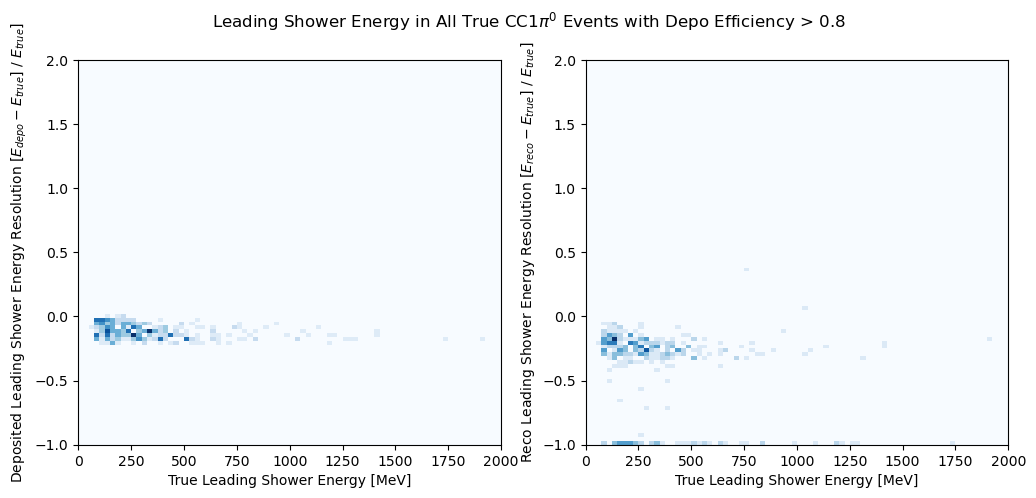

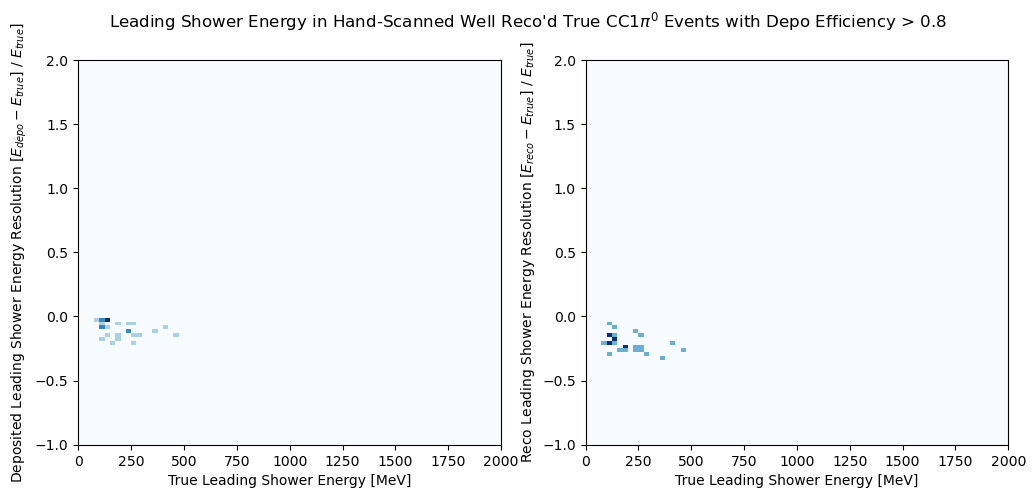

In [28]:

def make_lead_energy_shower_eres_2D_plots_from_df(df, energy_bins, energy_res_bins, bin_size, sample):

    num_events = len(df)
    fig, ax = plt.subplots(1,2,figsize=(12,5))
    reco_counts, reco_bins = np.histogram(df["lead_reco_E"], bins=energy_bins)
    depo_counts, depo_bins = np.histogram(df["lead_depo_E"], bins=energy_bins)
    true_counts, true_bins = np.histogram(df["lead_available_E"], bins=energy_bins)
    ax[0].hist2d(df["lead_available_E"], df["lead_E_depo_res"], bins=[energy_bins, energy_res_bins], cmap='Blues')
    ax[0].set_xlabel('True Leading Shower Energy [MeV]')
    ax[0].set_ylabel('Deposited Leading Shower Energy Resolution [$E_{depo}-E_{true}$] / $E_{true}$]')

    ax[1].hist2d(df["lead_available_E"], df["lead_E_reco_res"], bins=[energy_bins, energy_res_bins], cmap='Blues')
    ax[1].set_xlabel('True Leading Shower Energy [MeV]')
    ax[1].set_ylabel('Reco Leading Shower Energy Resolution [$E_{reco}-E_{true}$] / $E_{true}$]')

    fig.suptitle(r'Leading Shower Energy in ' + sample)

    #plt.colorbar(label='Counts')

    plt.show()

make_lead_energy_shower_eres_2D_plots_from_df(depo_containment_df, energy_bins, energy_res_bins, energy_bins_size, "All True CC1$\pi^0$ Events with Depo Efficiency > "+str(depo_energy_cut))
make_lead_energy_shower_eres_2D_plots_from_df(good_reco_high_depo_events_df, energy_bins, energy_res_bins, energy_bins_size, "Hand-Scanned Well Reco'd True CC1$\pi^0$ Events with Depo Efficiency > "+str(depo_energy_cut))
